In [364]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random

from ultranest import ReactiveNestedSampler
import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import Angle, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats



import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preparation

In [209]:
G = pd.read_csv("groups_cherrey_2023.csv", index_col = False)

f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True

G_abs = G[f8 & f14 & f13]
G_noabs = G[~f8 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[~f8 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
G5_abs = G[f9 & f13 & f14 & f8]
G5_noabs = G[f9 & f13 & f14 & ~f8]

In [210]:
R = pd.read_csv("results_8_conservative.csv")

bad_runs_ids = [11083, 12121, 23086, 26092, 28102, 30070, 30093]
#Note that some of these Ids are not isolated or closest galaxies

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/(10**R["sed_logMass"]))
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-11)
R["v_sig"] = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"]

R_all = R.copy()

In [211]:
no_morpho_isol = [11083, 12103, 17072, 20077, 23086, 24038, 27094, 30070]
no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 12123, 12127, 12128, 14075, 14134, \
                    14144, 16087, 16094, 16095, 17034, 17072, 17088, 19002, 19085, 19090, 20055, 20057, \
                    20060, 20073, 20074, 20077, 20097, 21099, 22088, 22093, 23086, 23123, 23132, 23136,\
                    23155, 23161, 24029, 24038, 24053, 25074, 25087, 26056, 26084, 26086, 26092, 27069, \
                    27076, 27094, 27101, 28075, 28080, 28091, 28102, 29062, 29081, 29083, 29084, 30039, \
                    30070, 30087, 30093, 30109, 31042, 31121, 32974, 32075]

no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 14075, 14134, 14144, 15045, 16087, 16094, 16095,\
                    17034, 17073, 17088, 19002, 19085, 19090, 20057, 20060, 20073, 20074, 20077, \
                    20097, 21099, 22088, 22093, 23086, 23094, 23123, 23132, 23155, 23161,\
                    24029, 24038, 24053, 25087, 26084, 26086, 26092, 27053, 27063, 27069, 27076, 27094,\
                    27101, 28075, 28080, 28102, 29062, 29083, 29084, 30039, 30070, 30087, 30093, 30109, \
                    31042, 31121, 32063, 32074, 32075]

rerun_on_OIII = [11106, 12028, 12092, 12123, 12128, 14109, 17073, 19066, 19090, 20046,23098, 24053]
rerun_on_Hb = [12128, 16075, 29084]
rerun_on_Ha = [16063]
rerun_with_mask = [23094, 23123]

to_remove = [24052, 11083] # because MgII abs contaminated by other absorption.


no_morpho = no_morpho_closest + no_morpho_isol

In [212]:
def isolated_auto_modif4(df, b_max = 150, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    isol = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
                if (len(Fbmax) == 1) & (len(Fbsep)==1):
                    p = 1
                # .. or the closest one (not taking into account satellites)
                else:
                    p = 0
        isol.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    ISOL = np.array(isol)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["isolated_auto"] = ISOL
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

In [213]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
#R = isolated_auto_modif4(R, b_max = 125, b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [1047]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
fremove = R["ID"].isin(to_remove)
finrisol = R["B_KPC"]< gt.get_Rvir(10**(11.7), R["Z"])

In [1056]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_15_zconf1_inrisol = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass & finrisol]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]


R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R150_snr3_rot = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1 & frot]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & fabs]
isol_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & ~fabs]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind & ~fremove]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind & ~fremove] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind & ~fremove]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & ~fremove] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind & ~fremove]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & ~fremove] # good runs

#---- from visual inspection----
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove]
isol_visu_nok_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & fabs]
isol_visu_nok_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & ~fabs]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_disp = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove]
isol_visu_disp_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & fabs]
isol_visu_disp_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & ~fabs]

isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]

isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_low_incl_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & fabs]
isol_visu_low_incl_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & ~fabs]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_mid_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fremove]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]


#----

isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad]

closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]

closest_visu = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
closest_visu_nok = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho]
closest_visu_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs]
closest_visu_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs]
closest_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot]
closest_visu_disp = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot]
closest_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs]
closest_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs]
closest_incl_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot]
closest_incl_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot]
closest_incl_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot]

closest_visu_low_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot]
closest_visu_high_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha]
closest_visu_high_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & fabs]
closest_visu_high_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fabs]

closest_visu_mid_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida]
closest_visu_mid_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & fabs]
closest_visu_mid_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fabs]
closest_visu_low_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa]
closest_visu_low_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & fabs]
closest_visu_low_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fabs]


print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))

print("")
print("Number of isolated galaxies with morpho ok (visual) : ", len(isol_visu))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 : ", len(isol_incl_visu_rot))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and high alpha : ", len(isol_visu_high_alpha))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and mid alpha : ", len(isol_visu_mid_alpha))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and low alpha : ", len(isol_visu_low_alpha))


print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground and isolated:", len(isol))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground and isolated and log(M) > 9:", len(isol_9))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

print("")
print("Nb of foreground galaxies with zconf >= 1: ", len(R[fqso & fstar & fzconf_0 & fbehind]))
print("Nb of foreground galaxies with zconf >= 2: ", len(R[fqso & fstar & fzconf_1 & fbehind]))
print("Nb of foreground galaxies with zconf >= 1 in Risol: ", len(R[fqso & fstar & fzconf_0 & fbehind & finrisol]))
print("Nb of foreground galaxies with zconf >= 2 in Risol: ", len(R[fqso & fstar & fzconf_1 & fbehind & finrisol]))
print("Nb of foreground galaxies with zconf >= 1 in 0.4-1.5: ", \
      len(R[fzlow & fzhigh & fqso & fstar & fzconf_0 & fbehind]))
print("Nb of foreground galaxies with zconf >= 2 in 0.4-1.5: ", \
      len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind]))
print("Nb of foreground galaxies with zconf >= 1 in 0.4-1.5 in Risol: ", \
      len(R[fzlow & fzhigh & fqso & fstar & fzconf_0 & fbehind & finrisol]))
print("Nb of foreground galaxies with zconf >= 2 in 0.4-1.5 in Risol: ", \
      len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind & finrisol]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  144
Number of isolated with abs =  42
Number of distinct absorptions associated with isolated  =  42
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  69
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  49
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  48
Number of isolated with logM > 9 and good galpak runs  =  70
Number of isolated with logM > 9 and good galpak runs and incl>30 =  38
Number of closest galax

In [216]:
len(isol_9)

72

In [1045]:
len(Rforeground)

1210

In [217]:
len(isol_visu_rot)

59

In [218]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "pure_isolated_catalog_2024_02_05")

In [219]:
len(isol)
np.median(isol_9["sed_logMass"])

9.792908012866974

In [220]:
gt.Behroozi(np.mean(R_04_15["sed_logMass"]), np.mean(R_04_15["Z"]))

11.470818421845802

In [221]:
len(isol_9_abs)

33

In [222]:
np.mean(R_04_15["Z"])

0.9066748481166466

# Completeness

[Text(0, 6.0, ''),
 Text(0, 7.0, ''),
 Text(0, 8.0, ''),
 Text(0, 9.0, ''),
 Text(0, 10.0, ''),
 Text(0, 11.0, ''),
 Text(0, 12.0, ''),
 Text(0, 13.0, '')]

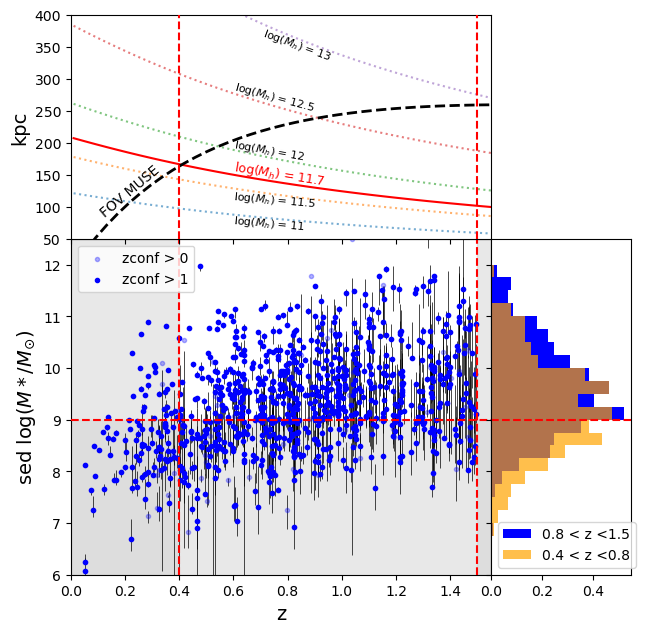

In [223]:
zz = np.linspace(0.01, 1.6, 40)
m11 = 10**(11)
m115 = 10**(11.5)
m117 = 10**(11.7)
m12 = 10**(12)
m125 = 10**(12.5)
m13 = 10**(13)
r11 = gt.get_Rvir(m11, zz)
r115 = gt.get_Rvir(m115, zz)
r117 = gt.get_Rvir(m117, zz)
r12 = gt.get_Rvir(m12, zz)
r125 = gt.get_Rvir(m125, zz)
r13 = gt.get_Rvir(m13, zz)

rr_fov = cosmo.kpc_proper_per_arcmin(zz)/2

Mmax = 12.5
Mmin = 6

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7, 7), dpi = 100)
gs = fig.add_gridspec(5, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
# Create the Axes.
ax = fig.add_subplot(gs[2:5, 0:3])
ax_fov = fig.add_subplot(gs[0:2, 0:3])
ax_histy = fig.add_subplot(gs[2:5, 3:4])


#---------------------------
#plt.title("Rvir vs Rfov", size = 20)
ax_fov.plot(zz, r11, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r115, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r117, label = "Rvir of logMh = 11.7", c = "r")
ax_fov.plot(zz, r12, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r125, alpha = 0.6, linestyle = "dotted")
ax_fov.plot(zz, r13, alpha = 0.6, linestyle = "dotted")

ax_fov.text(0.6, 65, '$\log(M_h)$ = 11', fontsize = 8, color = 'black', rotation = -5);
ax_fov.text(0.6, 100, '$\log(M_h)$ = 11.5', fontsize = 8, color = 'black', rotation = -5);
ax_fov.text(0.6, 135, '$\log(M_h)$ = 11.7', fontsize = 9, color = 'red', rotation = -9);
ax_fov.text(0.6, 173, '$\log(M_h)$ = 12', fontsize = 8, color = 'black', rotation = -10);
ax_fov.text(0.6, 250, '$\log(M_h)$ = 12.5', fontsize = 8, color = 'black', rotation = -15);
ax_fov.text(0.7, 330, '$\log(M_h)$ = 13', fontsize = 8, color = 'black', rotation = -20);
ax_fov.text(0.1, 85, 'FOV MUSE', fontsize = 10, color = 'black', rotation = 40);


ax_fov.plot(zz, rr_fov, label = "Rfov", c = "black", linewidth = 2, linestyle = "--")
#ax_fov.legend()
#ax_fov.xlabel("z", size = 15)
#ax_fov.ylabel("kpc", size = 15)
ax_fov.set_xlim((0, 1.55))
ax_fov.set_xticklabels([])
ax_fov.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
ax_fov.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
ax_fov.set_ylabel("kpc", size = 14)
ax_fov.set_ylim((50, 400))
#-----------------------
ax.vlines(Rforeground_mass["Z"], Rforeground_mass["sed_logMass_l95"], Rforeground_mass["sed_logMass_u95"], \
          color = "black", linewidth = 0.5, zorder = 2)
ax.scatter(Rforeground_mass["Z"], Rforeground_mass["sed_logMass"],  marker='.', c = "blue", alpha = 0.3,\
                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["sed_logMass"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", alpha = 0.3, zorder = 3)
ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", zorder = 3)
ax.set_ylim((Mmin, Mmax))
ax.set_xlim((0, 1.55))
ax.set_xlabel("z", size = 14)
ax.set_ylabel("sed $\log(M*/M_{\odot}$)", size = 14)
ax.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
ax.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
ax.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
#ax.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
ax.axhline(9, c = 'r', linestyle = "--", zorder = 4)
ax.axvspan(0, 0.4, color='lightgray', alpha=0.5, zorder = 1)
ax.axvspan(1.5, 2., color='lightgray', alpha=0.5, zorder = 1)
ax.axhspan(3, 9., color='lightgray', alpha=0.5,zorder = 1)

#-----------------------------

#plt.legend()
binsize = 0.25

nbins = int((Mmax - Mmin)/binsize)
ax_histy.hist(R_08_15_zconf1["sed_logMass"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.8 < z <1.5", density = True);
ax_histy.hist(R_04_08_zconf1["sed_logMass"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
#ax_histy.set_yticklabels([]);
ax_histy.axhline(9, c = 'r', linestyle = "--", zorder = 2)
ax_histy.set_ylim((Mmin, Mmax))
ax_histy.legend()
ax_histy.set_yticklabels([])

Text(0, 0.5, 'log(SFR)')

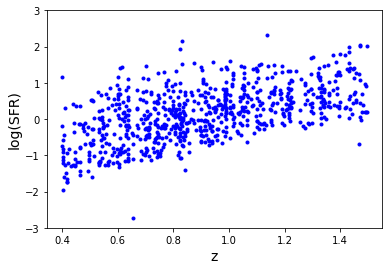

In [224]:
plt.scatter(R_04_15_zconf1["Z"], R_04_15_zconf1["logSFR"], c = "blue", marker = ".")
plt.ylim((-3,3))
plt.xlabel("z", size = 14)
plt.ylabel("log(SFR)", size = 14)

# Galaxy properties

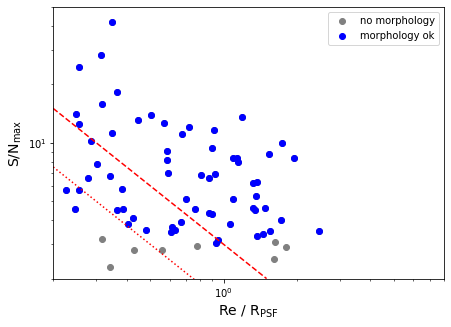

In [225]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (7,5))
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


ax_fov.text(0.6, 65, '$\log(M_h)$ = 11', fontsize = 8, color = 'red', rotation = -5);

X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

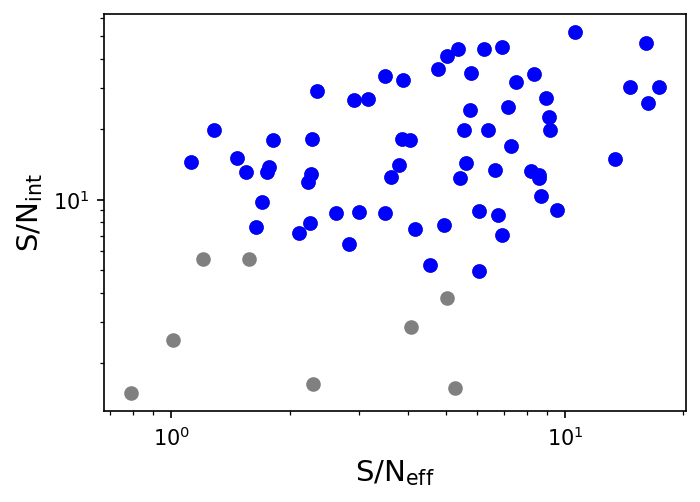

In [352]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (5,3.5), dpi = 150)
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_lowM["snr_eff"], isol_lowM["snr_from_src"], c = "gray", marker = "x")
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N$_{\mathrm{eff}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{int}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

X = np.array(isol_visu["snr_eff"])
Y = np.array(isol_visu["snr_from_src"])
txt = np.array(isol_visu["ID"])

#for i in range(len(isol_visu)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

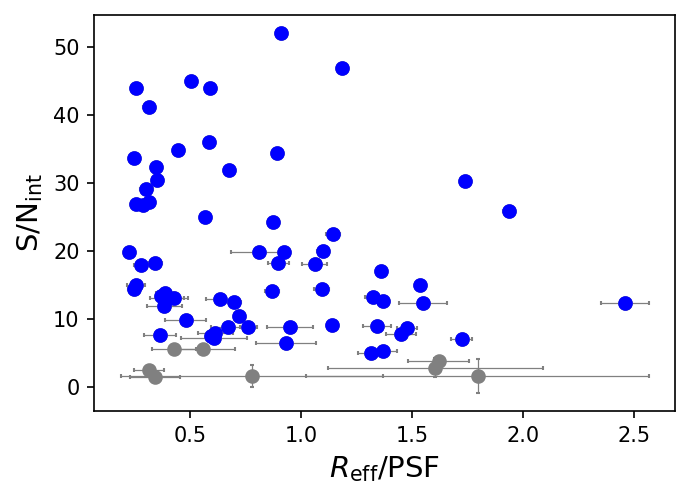

In [843]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (5,3.5), dpi = 150)
plt.errorbar(np.array(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"]), np.array(isol_9["snr_from_src"]), \
            np.array(isol_9["radius_err"]), \
            xerr = np.array(isol_9["radius_err"]*muse_sampling/isol_9["psf_fwhm"]), \
             color = "gray", linestyle = "None", linewidth = 0.6, zorder = 0, capsize = 1)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_from_src"], c = "gray",zorder = 1)
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho", zorder = 2)
plt.xlabel("$R_{\mathrm{eff}}/$PSF", size = 14)
plt.ylabel("S/N$_{\mathrm{int}}$", size = 14)


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

#for i in range(len(isol_visu_nok)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

X = np.array(isol_visu["snr_eff"])
Y = np.array(isol_visu["snr_from_src"])
txt = np.array(isol_visu["ID"])

#for i in range(len(isol_visu)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

In [227]:
len(isol_9)

72

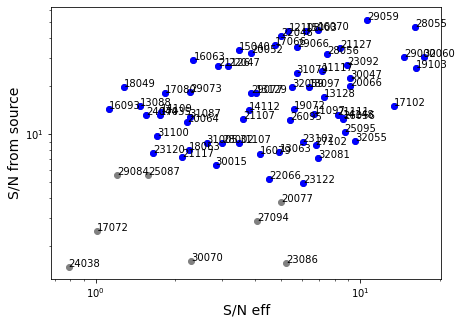

In [228]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(figsize = (7,5))
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_lowM["snr_eff"], isol_lowM["snr_from_src"], c = "gray", marker = "x")
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

X = np.array(isol_visu["snr_eff"])
Y = np.array(isol_visu["snr_from_src"])
txt = np.array(isol_visu["ID"])

for i in range(len(isol_visu)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

(1, 100)

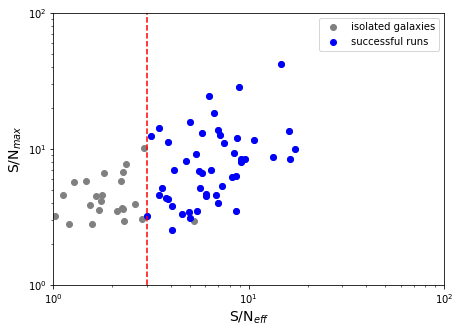

In [229]:
plt.figure(figsize = (7,5))
plt.scatter(isol_9["snr_eff"], isol_9["snr_max"], c = "gray", label = "isolated galaxies")
plt.scatter(isol_snr3_good_runs["snr_eff"], isol_snr3_good_runs["snr_max"], c = "blue", label = "successful runs")
plt.legend()
plt.xlabel("S/N$_{eff}$", size = 14)
plt.ylabel("S/N$_{max}$", size = 14)
plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlim((1,100))
plt.ylim((1,100))

Nb of isolated galaxies with morpho Ok 64


(0.0, 90.0)

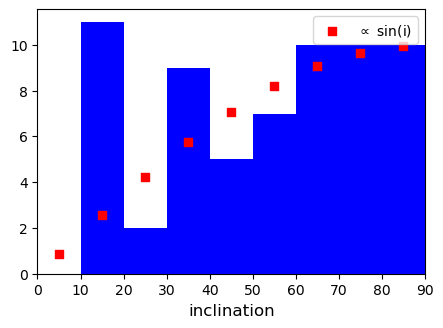

In [388]:
ii = np.linspace(5, 85, 9)
plt.figure(figsize = (5,3.5), dpi = 100)
print("Nb of isolated galaxies with morpho Ok", len(isol_visu))
plt.hist(isol_visu["inclination"], bins = 9, range = (0,90), color = "blue");
plt.scatter(ii, np.sin(ii*2*np.pi/360)*10, c = "r", zorder = 3, marker = "s", label = "$\propto$ sin(i)")
plt.legend()
plt.xlabel("inclination", size = 12)
plt.xlim((0,90))

Nb of isolated galaxies with morpho Ok 48


(0.0, 90.0)

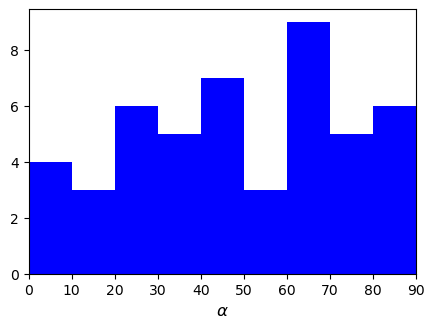

In [231]:
ii = np.linspace(5, 85, 9)
plt.figure(figsize = (5,3.5), dpi = 100)
print("Nb of isolated galaxies with morpho Ok", len(isol_incl_visu_rot))
plt.hist(isol_incl_visu_rot["alpha"], bins = 9, range = (0,90), color = "blue");
#plt.scatter(ii, np.sin(ii*2*np.pi/360)*12, c = "r", zorder = 3, marker = "s", label = "$\propto$ sin(i)")
plt.xlabel("$\\alpha$", size = 12)
plt.xlim((0,90))

### KS test for these distributions

#### For alpha

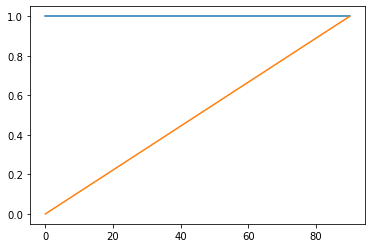

In [450]:
xx = np.linspace(0, 90, 100)
plt.plot(xx, np.ones(len(xx)))
plt.plot(xx, xx/90)

In [457]:

def cdf_flat(x):
    return x/90

#ii = np.linspace(5, 85, 9)
#hist_incl = np.histogram(isol_visu["inclination"], bins = 9, range = (0,90))
statistic, p_value = stats.kstest(isol_incl_visu_rot["alpha"], cdf_flat)
print("p-value: ", p_value)
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis (the distributions are different)")
else:
    print("Fail to reject the null hypothesis (the distributions are the same)")

p-value:  0.5592713407370364
Fail to reject the null hypothesis (the distributions are the same)


#### For inclination

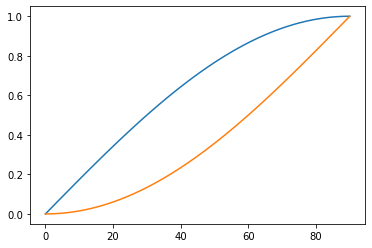

In [439]:
xx = np.linspace(0, 90, 100)
plt.plot(xx, np.sin(xx*2*np.pi/360))
plt.plot(xx, 1- np.cos(xx*2*np.pi/360))

In [839]:

def cdf_sin(x):
    return 1 - np.cos(x*2*np.pi/360)

#ii = np.linspace(5, 85, 9)
#hist_incl = np.histogram(isol_visu["inclination"], bins = 9, range = (0,90))
statistic, p_value = stats.kstest(isol_visu["inclination"], cdf_sin)
print("p-value: ", p_value)
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis (the distributions are different)")
else:
    print("Fail to reject the null hypothesis (the distributions are the same)")

p-value:  0.24555367311919107
Fail to reject the null hypothesis (the distributions are the same)


Nb of isolated galaxies with logM>9 : 72


Text(0, 0.5, 'log(SFR)')

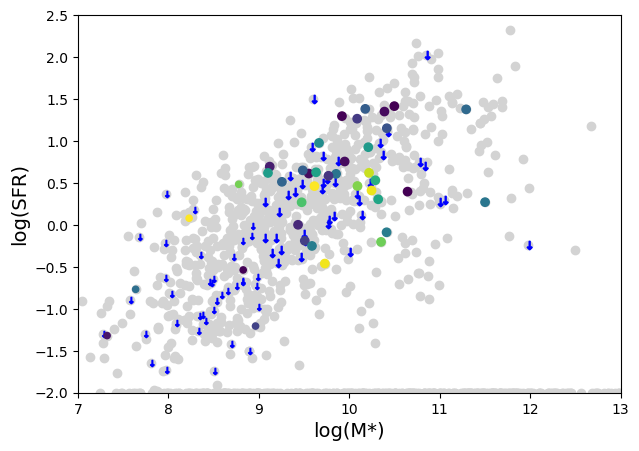

In [232]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6

plt.scatter(R["sed_logMass"], R["logSFR"], c = 'lightgray')
plt.scatter(isol_9_abs["sed_logMass"], isol_9_abs["logSFR"], c = isol_9_abs["REW_2796"],\
                 zorder = 2)
            
plt.scatter(isol_9_noabs["sed_logMass"], isol_9_noabs["logSFR"], c = "blue",\
             marker = "$\downarrow$")

plt.scatter(isol_lowM_abs["sed_logMass"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
                 zorder = 2, s = 20)
            
plt.scatter(isol_lowM_noabs["sed_logMass"], isol_lowM_noabs["logSFR"], c = "blue",\
             marker = "$\downarrow$", s = 20)

plt.ylim((-2, 2.5))
plt.xlim((7, 13))
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("log(M*)", size = 14)
plt.ylabel("log(SFR)", size = 14)
#plt.legend()

# W-b

## whole sample

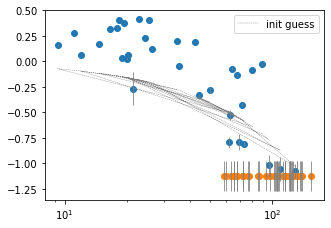

In [233]:
x1 = np.array(isol_9_abs["B_KPC"])
x2 = np.array(isol_9_noabs["B_KPC"])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

plt.figure(figsize = (5,3.5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.errorbar(x1, y1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "gray", linestyle = "--", linewidth = 0.4)
plt.legend()
plt.xscale("log")

In [234]:
fit_9 = minimize(gt.logL_stats_total, np.array([0.3,-0.01, 0.3]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_9

      fun: 38.574782398374026
 hess_inv: array([[ 1.85030719e-02, -2.50345469e-04,  1.07925306e-03],
       [-2.50345469e-04,  4.83511584e-06, -5.44877337e-05],
       [ 1.07925306e-03, -5.44877337e-05,  4.13853191e-03]])
      jac: array([ 0.00000000e+00, -7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([ 0.54751864, -0.02068996,  0.47002684])

In [ ]:
0.47

In [235]:
np.diag(fit_9.hess_inv)**0.5

array([0.136026  , 0.00219889, 0.06433142])

**with updated method to have sigma_c not in log:**

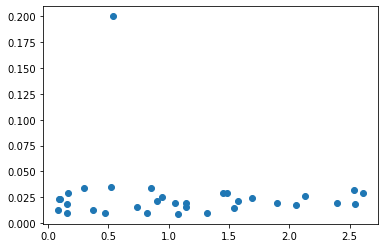

In [690]:
plt.scatter(isol_9_abs["REW_2796"], isol_9_abs["sig_REW_2796"])

In [722]:
x1 = np.array(isol_9_abs["B_KPC"])
x2 = np.array(isol_9_noabs["B_KPC"])
y1 = np.array(isol_9_abs["REW_2796"])
y2 = np.array(isol_9_noabs["detection_limit_p75"])
sig_y1 = np.array(np.maximum(isol_9_abs["sig_REW_2796"], 0.025))
sig_y2 = np.array(np.ones(len(x2))*0.005)

In [724]:
init = np.array([0.4,-0.01, 0.00])
fit_9 = minimize(gt.logL_stats_total2, init, \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_9

      fun: 12054.535938437777
 hess_inv: array([[ 5.36988105e-06, -1.15352836e-07,  0.00000000e+00],
       [-1.15352836e-07,  3.96061182e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 10
     njev: 18
   status: 0
  success: True
        x: array([ 0.56437382, -0.01396057,  0.        ])

In [725]:
fit_9_1sig = np.diag(fit_9.hess_inv)**0.5
fit_9_1sig_inf = fit_9['x'] - fit_9_1sig
fit_9_1sig_sup = fit_9['x'] + fit_9_1sig

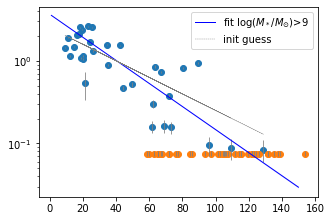

In [726]:
plt.figure(figsize = (5,3.5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.errorbar(x1, y1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)

plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)
plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "-", label = "fit $\log(M_*/M_{\odot})$>9")

plt.plot(x1, 10**(init[0] + init[1]*x1), label = "init guess", c = "gray", linestyle = "--", linewidth = 0.4)
plt.legend()
plt.yscale("log")

Nb of isolated galaxies with logM>9 : 72


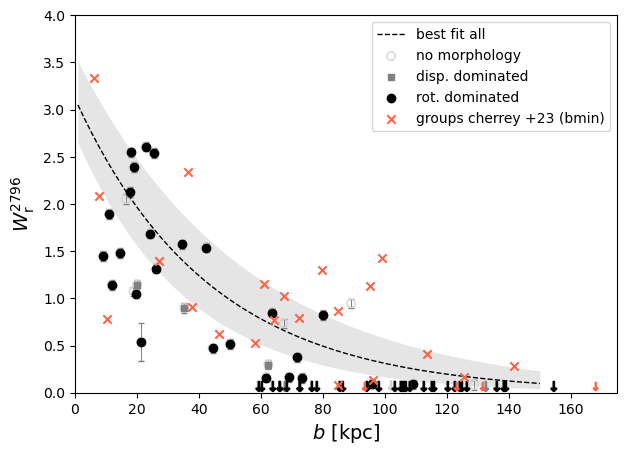

In [612]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(1, 150, 200)

plt.figure(dpi = 100, figsize = (7, 5))

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all")
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "gray", alpha = 0.2, linewidth = 0)

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], edgecolors = 'lightgray',\
                 zorder = 2, label = "no morphology", facecolors = "none")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'grey',\
                 zorder = 2, label = "disp. dominated", marker = "s", s = 25)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = 'black',\
                 zorder = 2, label = "rot. dominated")
plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]), \
             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 (bmin)")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], edgecolors = "lightgray",\
             marker = "$\downarrow$", facecolors = "none", s = 50)
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'grey',\
                 zorder = 2, marker = "$\downarrow$", s = 50)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = 'black',\
                 zorder = 2, marker = "$\downarrow$", s = 50)
#plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
#                 zorder = 2, marker = "$\downarrow$")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)

plt.xlim((0, 175))
plt.ylim((0, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

In [613]:
def Nielsen_2013(b):
    logW = -0.015*b + 0.27
    logW_inf = (-0.015 - 0.002)*b + 0.27-0.11
    logW_sup = (-0.015 + 0.002)*b + 0.27+0.11
    return 10**(logW), 10**(logW_inf), 10**(logW_sup)

def Cherrey_2024(b):
    logW = -0.018*b + 0.6
    logW_inf = (-0.017 - 0.001)*b + 1.14 - 0.005
    logW_sup = (-0.017 + 0.001)*b + 1.14 + 0.005
    return np.exp(logW), np.exp(logW_inf), np.exp(logW_sup)

def Huang_2021(b):
    #logW = -0.72*np.log10(b) + 0.83
    #logW_inf = (-0.72 - 0.25)*np.log10(b) + 0.83-0.38
    #logW_sup = (-0.72 + 0.25)*np.log10(b) + 0.83+0.38
    logW = -0.78*np.log10(b) + 0.94
    logW_inf = (-0.78 - 0.2)*np.log10(b) + 0.94-0.3
    logW_sup = (-0.78 + 0.2)*np.log10(b) + 0.94+0.3
    return 10**(logW), 10**(logW_inf), 10**(logW_sup)

def Dutta_2021(b):
    logW = -0.006*b - 0.13
    logW_inf = (-0.006 - 0.003)*b - 0.13-0.33
    logW_sup = (-0.006 + 0.002)*b - 0.13+0.31
    return 10**(logW), 10**(logW_inf), 10**(logW_sup)

Nb of isolated galaxies with logM>9 : 72


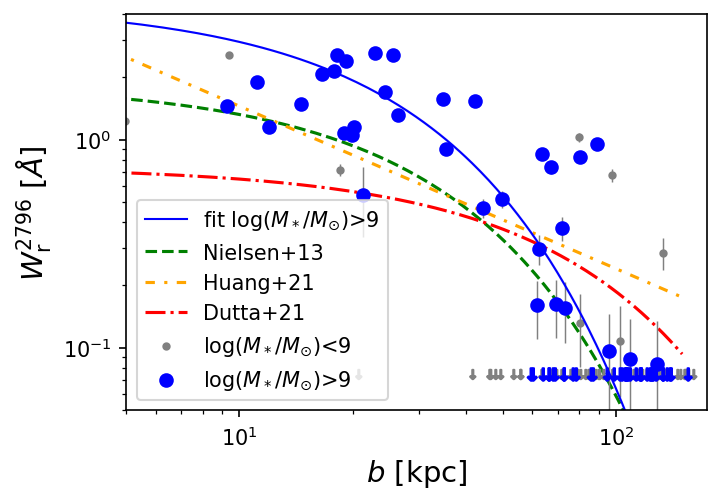

In [689]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(1, 150, 200)

W_N13, W_N13_inf, W_N13_sup = Nielsen_2013(X)
W_C24, W_C24_inf, W_C24_sup = Cherrey_2024(X)
W_H21, W_H21_inf, W_H21_sup = Huang_2021(X)
W_D21, W_D21_inf, W_D21_sup = Dutta_2021(X)



plt.figure(dpi = 150, figsize = (5, 3.5))


plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["REW_2796"], marker = ".", c = "grey",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(isol_abs["B_KPC"]), np.array(isol_abs["REW_2796"]), \
             yerr = np.maximum(isol_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)

plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["detection_limit_p75"], c = "grey",\
            marker = "$\downarrow$", s = 20)

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
#plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]), \
#             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05),\
#            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
#           label = "groups cherrey +23 ($b_{\mathrm{min}}$)")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$")
#plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
#                 zorder = 2, marker = "$\downarrow$")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)
plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "-", label = "fit $\log(M_*/M_{\odot})$>9")

plt.plot(X, W_N13, linewidth = 1.5, c = "green", \
         linestyle = "--", label = "Nielsen+13", zorder = 0)
#plt.plot(X, W_N13_inf, linewidth = 1, c = "green", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_N13_sup, linewidth = 1, c = "green", \
#         linestyle = "dotted", zorder = 0)

#plt.plot(X, W_C24, linewidth = 1, c = "tomato", \
#         linestyle = "--", label = "Cherrey+24 groups")
#plt.plot(X, W_C24_inf, linewidth = 1, c = "tomato", \
#         linestyle = "dotted")
#plt.plot(X, W_C24_sup, linewidth = 1, c = "tomato", \
#         linestyle = "dotted")

plt.plot(X, W_H21, linewidth = 1.5, c = "orange", \
         linestyle = (0,(3,3,1,3)), label = "Huang+21", zorder = 0)
#plt.plot(X, W_H21_inf, linewidth = 1, c = "orange", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_H21_sup, linewidth = 1, c = "orange", \
#         linestyle = "dotted", zorder = 0)

plt.plot(X, W_D21, linewidth = 1.5, c = "red", \
         linestyle = "dashdot", label = "Dutta+21", zorder = 0)
#plt.plot(X, W_D21_inf, linewidth = 1, c = "red", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_D21_sup, linewidth = 1, c = "red", \
#         linestyle = "dotted", zorder = 0)


plt.xlim((5, 175))
plt.ylim((0.05, 4))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size = 14)
plt.legend()

Nb of isolated galaxies with logM>9 : 72


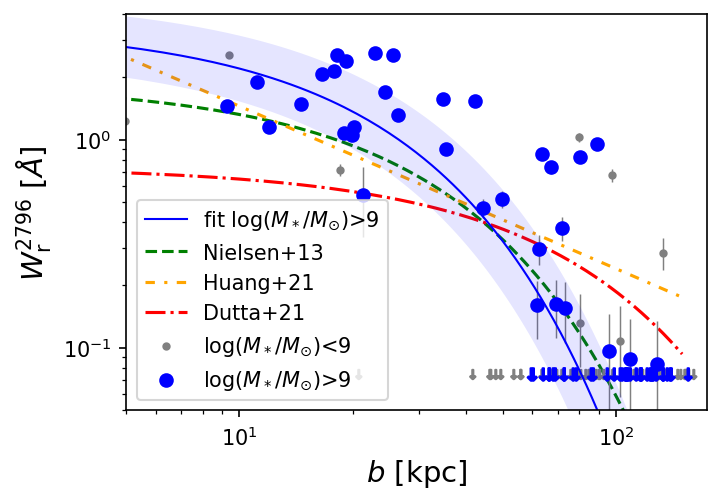

In [458]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(1, 150, 200)

W_N13, W_N13_inf, W_N13_sup = Nielsen_2013(X)
W_C24, W_C24_inf, W_C24_sup = Cherrey_2024(X)
W_H21, W_H21_inf, W_H21_sup = Huang_2021(X)
W_D21, W_D21_inf, W_D21_sup = Dutta_2021(X)



plt.figure(dpi = 150, figsize = (5, 3.5))


plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["REW_2796"], marker = ".", c = "grey",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(isol_abs["B_KPC"]), np.array(isol_abs["REW_2796"]), \
             yerr = np.maximum(isol_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)

plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["detection_limit_p75"], c = "grey",\
            marker = "$\downarrow$", s = 20)

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
#plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]), \
#             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05),\
#            linestyle = "none", linewidth = 0.7, c = "grey", capsize=0, zorder = 1)
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
#           label = "groups cherrey +23 ($b_{\mathrm{min}}$)")

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$")
#plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
#                 zorder = 2, marker = "$\downarrow$")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)
plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "-", label = "fit $\log(M_*/M_{\odot})$>9")

plt.plot(X, W_N13, linewidth = 1.5, c = "green", \
         linestyle = "--", label = "Nielsen+13", zorder = 0)
#plt.plot(X, W_N13_inf, linewidth = 1, c = "green", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_N13_sup, linewidth = 1, c = "green", \
#         linestyle = "dotted", zorder = 0)

#plt.plot(X, W_C24, linewidth = 1, c = "tomato", \
#         linestyle = "--", label = "Cherrey+24 groups")
#plt.plot(X, W_C24_inf, linewidth = 1, c = "tomato", \
#         linestyle = "dotted")
#plt.plot(X, W_C24_sup, linewidth = 1, c = "tomato", \
#         linestyle = "dotted")

plt.plot(X, W_H21, linewidth = 1.5, c = "orange", \
         linestyle = (0,(3,3,1,3)), label = "Huang+21", zorder = 0)
#plt.plot(X, W_H21_inf, linewidth = 1, c = "orange", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_H21_sup, linewidth = 1, c = "orange", \
#         linestyle = "dotted", zorder = 0)

plt.plot(X, W_D21, linewidth = 1.5, c = "red", \
         linestyle = "dashdot", label = "Dutta+21", zorder = 0)
#plt.plot(X, W_D21_inf, linewidth = 1, c = "red", \
#         linestyle = "dotted", zorder = 0)
#plt.plot(X, W_D21_sup, linewidth = 1, c = "red", \
#         linestyle = "dotted", zorder = 0)


plt.xlim((5, 175))
plt.ylim((0.05, 4))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size = 14)
plt.legend()

(-2.0, 0.3)

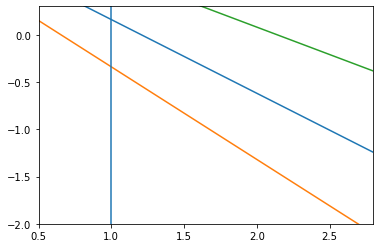

In [240]:
logbbb = np.linspace(0.5, 2.8, 100)
logW = -0.78*logbbb + 0.94
logW_inf = (-0.78 - 0.2)*logbbb + 0.94-0.3
logW_sup = (-0.78 + 0.2)*logbbb + 0.94+0.3
plt.plot(logbbb, logW)
plt.plot(logbbb, logW_inf)
plt.plot(logbbb, logW_sup)
plt.axvline(1)
plt.xlim((0.5, 2.8))
plt.ylim((-2, 0.3))

# Influence of mass

In [241]:
x1 = np.array(isol_abs["B_KPC"])
x2 = np.array(isol_noabs["B_KPC"])
y1 = np.array(np.log10(isol_abs["REW_2796"]))
y2 = np.array(np.log10(isol_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_abs["sig_REW_2796"]/isol_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)


In [242]:
fit_all = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_all_1sig = np.diag(fit_all.hess_inv)**0.5
fit_all_1sig_inf = fit_all['x'] - fit_all_1sig
fit_all_1sig_sup = fit_all['x'] + fit_all_1sig
fit_all

      fun: 82.26039849210113
 hess_inv: array([[ 2.99391701e-02, -3.75917406e-04,  1.30548070e-03],
       [-3.75917406e-04,  7.39486309e-06, -1.21986971e-04],
       [ 1.30548070e-03, -1.21986971e-04,  8.76068642e-03]])
      jac: array([0.00000000e+00, 1.90734863e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 132
      nit: 28
     njev: 33
   status: 0
  success: True
        x: array([ 0.29744969, -0.02259005,  0.7514116 ])

In [243]:
x1 = np.array(isol_lowM_abs["B_KPC"])
x2 = np.array(isol_lowM_noabs["B_KPC"])
y1 = np.array(np.log10(isol_lowM_abs["REW_2796"]))
y2 = np.array(np.log10(isol_lowM_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_lowM_abs["sig_REW_2796"]/isol_lowM_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [244]:
fit_lowM = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_lowM_1sig = np.diag(fit_lowM.hess_inv)**0.5
fit_lowM_1sig_inf = fit_lowM['x'] - fit_lowM_1sig
fit_lowM_1sig_sup = fit_lowM['x'] + fit_lowM_1sig
fit_lowM

      fun: 29.476847764524393
 hess_inv: array([[ 3.03481960e-01, -2.32149820e-03, -6.25921470e-02],
       [-2.32149820e-03,  5.68543152e-05, -1.52654675e-03],
       [-6.25921470e-02, -1.52654675e-03,  1.44766785e-01]])
      jac: array([ 4.76837158e-07, -4.29153442e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 160
      nit: 35
     njev: 40
   status: 0
  success: True
        x: array([-0.79666455, -0.0213003 ,  1.28502019])

Nb of isolated galaxies with logM>9 : 72


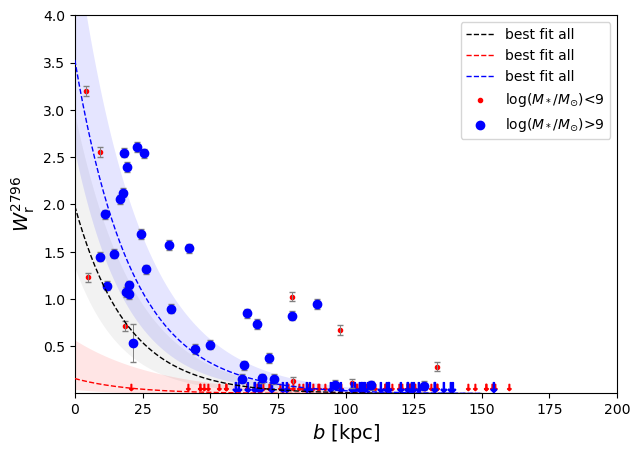

In [245]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))

X = np.linspace(0, 150, 200)

plt.figure(dpi = 100, figsize = (7, 5))

plt.plot(X, 10**gt.model(fit_all['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_all_1sig_inf, X), 10**gt.model(fit_all_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_lowM['x'], X), linewidth = 1.0, c = "red", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_lowM_1sig_inf, X), 10**gt.model(fit_lowM_1sig_sup, X), \
                 color = "red", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
                 color = "blue", alpha = 0.1, linewidth = 0)

plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["REW_2796"], marker = ".", c = "red",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
plt.errorbar(np.array(isol_abs["B_KPC"]), np.array(isol_abs["REW_2796"]), \
             yerr = np.maximum(isol_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)


plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["detection_limit_p75"], c = "red",\
            marker = "$\downarrow$", s = 20)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((0, 200))
plt.ylim((0.01, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

# Influence of inclination and azimuth

In [246]:
x1 = np.array(isol_low_alpha_abs["B_KPC"])
x2 = np.array(isol_low_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_low_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_low_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_low_alpha_abs["sig_REW_2796"]/isol_low_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [247]:
fit_lowa = minimize(gt.logL_stats_total, np.array([0.5,-0.04, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_lowa_1sig = np.diag(fit_lowa.hess_inv)**0.5
fit_lowa_1sig_inf = fit_lowa['x'] - fit_lowa_1sig
fit_lowa_1sig_sup = fit_lowa['x'] + fit_lowa_1sig
fit_lowa

      fun: 1.7398519592131596
 hess_inv: array([[ 4.19429764e-02, -9.03370264e-04,  4.04001018e-03],
       [-9.03370264e-04,  2.64829603e-05, -2.16601207e-04],
       [ 4.04001018e-03, -2.16601207e-04,  8.57292390e-03]])
      jac: array([1.49011612e-07, 6.72042370e-06, 2.08616257e-07])
  message: 'Optimization terminated successfully.'
     nfev: 136
      nit: 26
     njev: 34
   status: 0
  success: True
        x: array([ 0.68670903, -0.02730642,  0.23862688])

In [248]:
x1 = np.array(isol_high_alpha_abs["B_KPC"])
x2 = np.array(isol_high_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_high_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_high_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_high_alpha_abs["sig_REW_2796"]/isol_high_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [249]:
fit_higha = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_higha_1sig = np.diag(fit_higha.hess_inv)**0.5
fit_higha_1sig_inf = fit_higha['x'] - fit_higha_1sig
fit_higha_1sig_sup = fit_higha['x'] + fit_higha_1sig
fit_higha

      fun: 7.368114413281624
 hess_inv: array([[ 1.80463829e-02, -2.47375750e-04,  7.64783186e-04],
       [-2.47375750e-04,  4.88113240e-06, -2.95692927e-05],
       [ 7.64783186e-04, -2.95692927e-05,  3.54611992e-03]])
      jac: array([-2.38418579e-07,  0.00000000e+00, -2.98023224e-07])
  message: 'Optimization terminated successfully.'
     nfev: 116
      nit: 24
     njev: 29
   status: 0
  success: True
        x: array([ 0.64614937, -0.01761839,  0.3053608 ])

In [250]:
x1 = np.array(isol_mid_alpha_abs["B_KPC"])
x2 = np.array(isol_mid_alpha_noabs["B_KPC"])
y1 = np.array(np.log10(isol_mid_alpha_abs["REW_2796"]))
y2 = np.array(np.log10(isol_mid_alpha_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_mid_alpha_abs["sig_REW_2796"]/isol_mid_alpha_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [251]:
fit_mida = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_mida_1sig = np.diag(fit_mida.hess_inv)**0.5
fit_mida_1sig_inf = fit_mida['x'] - fit_mida_1sig
fit_mida_1sig_sup = fit_mida['x'] + fit_mida_1sig
fit_mida

      fun: 3.2559193839874228
 hess_inv: array([[ 1.42264806e+00, -2.26171154e-02,  9.85725805e-02],
       [-2.26171154e-02,  3.91943473e-04, -2.56908098e-03],
       [ 9.85725805e-02, -2.56908098e-03,  8.98432780e-02]])
      jac: array([ 1.63912773e-06, -9.65595245e-06,  3.12924385e-06])
  message: 'Optimization terminated successfully.'
     nfev: 124
      nit: 27
     njev: 31
   status: 0
  success: True
        x: array([ 1.83277377, -0.04553205,  0.53967549])

In [252]:
x1 = np.array(isol_visu_low_incl_abs["B_KPC"])
x2 = np.array(isol_visu_low_incl_noabs["B_KPC"])
y1 = np.array(np.log10(isol_visu_low_incl_abs["REW_2796"]))
y2 = np.array(np.log10(isol_visu_low_incl_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_visu_low_incl_abs["sig_REW_2796"]/isol_visu_low_incl_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [253]:
fit_lowi = minimize(gt.logL_stats_total, np.array([0.2,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_lowi_1sig = np.diag(fit_lowi.hess_inv)**0.5
fit_lowi_1sig_inf = fit_lowi['x'] - fit_lowi_1sig
fit_lowi_1sig_sup = fit_lowi['x'] + fit_lowi_1sig
fit_lowi

      fun: 2.5001246354824618
 hess_inv: array([[ 5.91861134e-02, -1.03641585e-03,  4.15127904e-03],
       [-1.03641585e-03,  2.85113306e-05, -3.76127532e-04],
       [ 4.15127904e-03, -3.76127532e-04,  2.04141147e-02]])
      jac: array([-4.67896461e-06, -8.19563866e-05, -1.37090683e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 224
      nit: 16
     njev: 53
   status: 2
  success: False
        x: array([ 0.42827768, -0.02514043,  0.26870562])

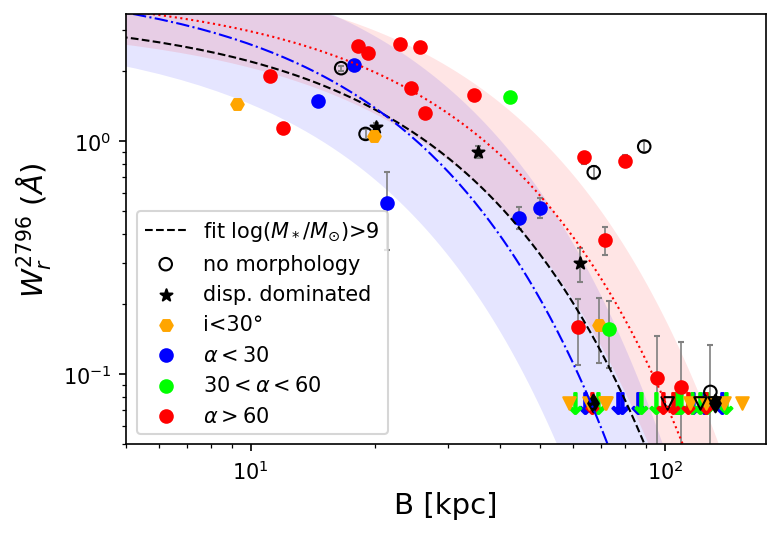

In [254]:
plt.figure(figsize = (5.5,3.8), dpi = 150)
X = np.linspace(0, 150, 200)

plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
#plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
#                 color = "gray", alpha = 0.2, linewidth = 0)

plt.plot(X, 10**gt.model(fit_lowa['x'], X), linewidth = 1.0, c = "blue", \
         linestyle = "dashdot")
#         linestyle = "dashdot", label = "best fit $\\alpha<30°$")
plt.fill_between(X, 10**gt.model(fit_lowa_1sig_inf, X), 10**gt.model(fit_lowa_1sig_sup, X), \
                color = "blue", alpha = 0.1, linewidth = 0)

plt.plot(X, 10**gt.model(fit_higha['x'], X), linewidth = 1.0, c = "red", \
            linestyle = "dotted")
#         linestyle = "dotted", label = "best fit $\\alpha>60°$")
plt.fill_between(X, 10**gt.model(fit_higha_1sig_inf, X), 10**gt.model(fit_higha_1sig_sup, X), \
                 color = "red", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_lowi['x'], X), linewidth = 1.0, c = "orange", \
#         linestyle = "dotted", label = "best fit $i<30°$")
#plt.fill_between(X, 10**gt.model(fit_lowi_1sig_inf, X), 10**gt.model(fit_lowi_1sig_sup, X), \
#                 color = "orange", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_mida['x'], X), linewidth = 1.0, c = "lime", \
#         linestyle = "dotted", label = "best fit $30°<\\alpha<60°$")
#plt.fill_between(X, 10**gt.model(fit_mida_1sig_inf, X), 10**gt.model(fit_mida_1sig_sup, X), \
#                 color = "lime", alpha = 0.1, linewidth = 0)

#-----------------------------------
#plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = "gray")
#plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], \
#            c = "gray", marker = "$\downarrow$", s = 100,)

plt.scatter(isol_visu_nok_abs["B_KPC"], isol_visu_nok_abs["REW_2796"], edgecolors = 'black',\
                 zorder = 2, label = "no morphology", facecolors = "none")
plt.scatter(isol_visu_disp_abs["B_KPC"], isol_visu_disp_abs["REW_2796"], c = 'black',\
                 zorder = 2, label = "disp. dominated", marker = "*")
plt.scatter(isol_visu_low_incl_abs["B_KPC"], isol_visu_low_incl_abs["REW_2796"], c = 'orange',\
                 zorder = 2, label = "i<30°", marker = "H")
plt.scatter(isol_visu_low_incl_noabs["B_KPC"], isol_visu_low_incl_noabs["detection_limit_p75"], c = 'orange',\
                 zorder = 2, marker = "v")
plt.scatter(isol_visu_nok_noabs["B_KPC"], isol_visu_nok_noabs["detection_limit_p75"], edgecolors = 'black',\
                 zorder = 2, facecolors = "none", marker = "v")
plt.scatter(isol_visu_disp_noabs["B_KPC"], isol_visu_disp_noabs["detection_limit_p75"], c = 'black',\
                 zorder = 2, marker = "d")
plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]),\
             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05), \
             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1, capsize = 1.3)
#plt.errorbar(np.array(isol_9_noabs["B_KPC"]), np.array(isol_9_noabs["detection_limit_p75"]),\
#             yerr = np.maximum(isol_9_noabs["detection_limit_p75"], 0.05), \
#             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1)


plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = "blue", zorder = 2, \
            label = "$\\alpha<30$")
plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "blue")

plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = "lime", zorder = 2,\
           label = "$30 < \\alpha<60$")
plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "lime")

plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = "red", zorder = 2,\
           label = "$\\alpha>60$")
plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "red")




plt.xlabel("B [kpc]", size = 14)
plt.ylabel("$W_r^{2796}$ ($\AA$)", size = 14)
plt.ylim((0.05, 3.5))
plt.xlim((5, 175))
plt.legend()
plt.yscale("log")
plt.xscale("log")

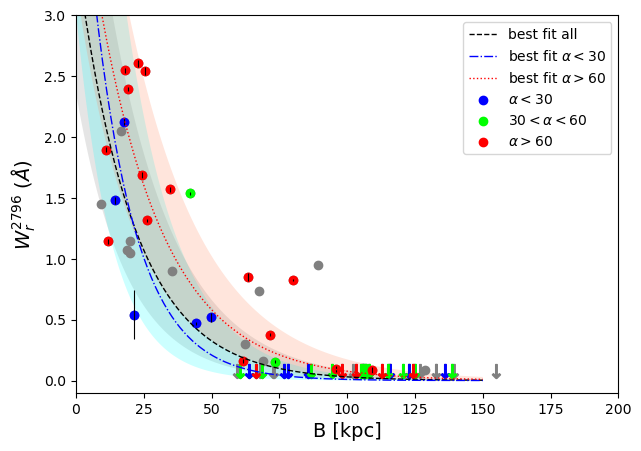

## 2D plots

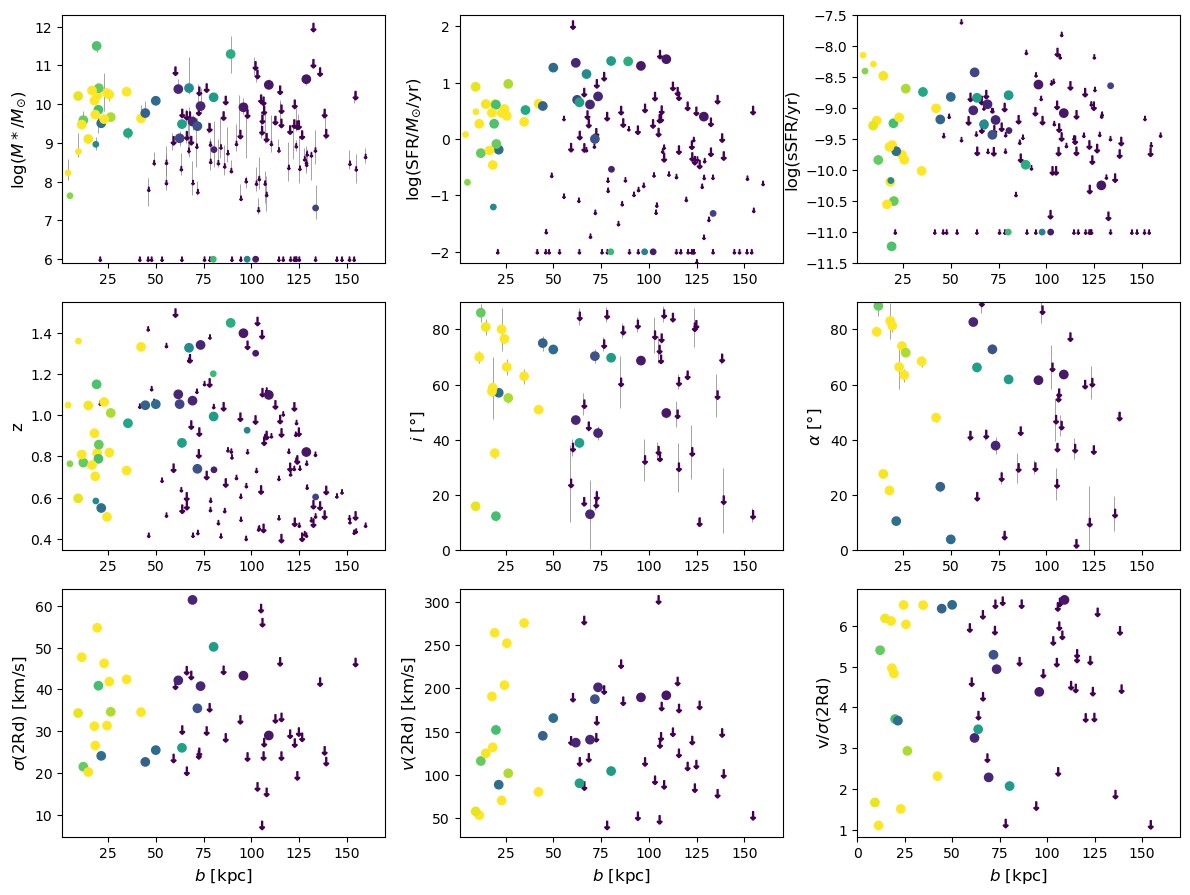

In [255]:
plt.figure(dpi = 100, figsize = (12, 9))

plt.subplot(331)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["sed_logMass"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["sed_logMass"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.vlines(isol["B_KPC"], isol["sed_logMass_l95"], isol["sed_logMass_u95"],\
          color = "grey", linewidth = 0.5, zorder = 0)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["sed_logMass"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["sed_logMass"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((5.9, 12.3))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log($M*/M_{\odot}$)", size = 12)

plt.subplot(332)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["logSFR"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["logSFR"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSFR"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSFR"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-2.2, 2.2))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)

plt.subplot(333)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["logSSFR"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["logSSFR"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["logSSFR"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["logSSFR"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
plt.ylim((-11.5, -7.5))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("log(sSFR/yr)", size = 12)

plt.subplot(334)
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["Z"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["Z"], c = isol_9_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.scatter(isol_lowM_abs["B_KPC"], isol_lowM_abs["Z"], c = isol_lowM_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5, marker = "o", s = 15)
plt.scatter(isol_lowM_noabs["B_KPC"], isol_lowM_noabs["Z"], c = isol_lowM_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5, s = 10)
plt.xlim((1, 170))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("z", size = 12)

plt.subplot(335)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["inclination"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.errorbar(np.array(isol_visu_rot["B_KPC"]), np.array(isol_visu_rot["inclination"]), \
             yerr = np.array(isol_visu_rot["inclination_err"]),\
                 linestyle = "none", color = "grey", linewidth = 0.5, zorder = 0)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["inclination"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.ylim((0,90))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$i$ [°]", size = 12)

plt.subplot(336)
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["alpha"],\
            c = isol_incl_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.errorbar(np.array(isol_incl_visu_rot["B_KPC"]), np.array(isol_incl_visu_rot["alpha"]), \
             yerr = np.array(isol_incl_visu_rot["pa_err"]%90),\
                 linestyle = "none", color = "grey", linewidth = 0.5, zorder = 0)
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["alpha"], \
            c = isol_incl_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.ylim((0,90))
#plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$\\alpha$ [°]", size = 12)

plt.subplot(337)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["velocity_dispersion_2Rd"], \
            c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["velocity_dispersion_2Rd"], \
            c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$\sigma$(2Rd) [km/s]", size = 12)

plt.subplot(338)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["v22"], c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["v22"], c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((1, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$v$(2Rd) [km/s]", size = 12)

plt.subplot(339)
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["v22"]/isol_visu_rot_abs["velocity_dispersion_2Rd"],\
            c = isol_visu_rot_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 1.5)
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["v22"]/isol_visu_rot_noabs["velocity_dispersion_2Rd"],\
            c = isol_visu_rot_noabs["REW_2796"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1.5)
plt.xlim((0, 170))
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("v/$\sigma$(2Rd)", size = 12)
plt.tight_layout()

In [256]:
isol_incl_visu_rot_abs_50 = isol_incl_visu_rot_abs[isol_incl_visu_rot_abs["B_KPC"]<50]
isol_incl_visu_rot_abs_100 = isol_incl_visu_rot_abs[isol_incl_visu_rot_abs["B_KPC"]<100]

isol_incl_visu_rot_noabs_50 = isol_incl_visu_rot_noabs[isol_incl_visu_rot_noabs["B_KPC"]<50]
isol_incl_visu_rot_noabs_100 = isol_incl_visu_rot_noabs[isol_incl_visu_rot_noabs["B_KPC"]<100]

Text(0.5, 0, '$\\alpha$')

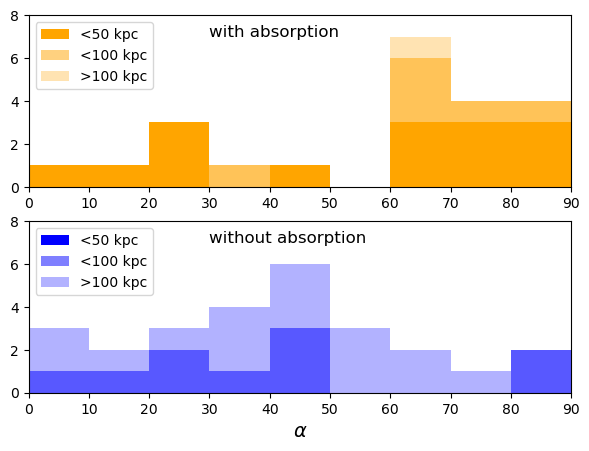

In [257]:
plt.figure(figsize = (7,5), dpi = 100)
plt.subplot(211)
plt.hist(isol_incl_visu_rot_abs_50["alpha"], range = (0,90), bins = 9, alpha = 1, color = "orange", label = "<50 kpc");
plt.hist(isol_incl_visu_rot_abs_100["alpha"], range = (0,90), bins = 9, alpha = 0.5, color = "orange", label = "<100 kpc");
plt.hist(isol_incl_visu_rot_abs["alpha"], range = (0,90), bins = 9, alpha = 0.3, color = "orange",label = ">100 kpc");
#plt.hist(isol_incl_visu_rot_noabs["alpha"], alpha  = 0.5);
plt.text(30, 7, "with absorption", size = 12)
plt.legend()
plt.xlim((0,90))
plt.ylim((0,8))


plt.subplot(212)
plt.hist(isol_incl_visu_rot_noabs_50["alpha"], range = (0,90), bins = 9, alpha = 1, color = "blue", label = "<50 kpc");
plt.hist(isol_incl_visu_rot_noabs_100["alpha"], range = (0,90), bins = 9, alpha = 0.5, color = "blue", label = "<100 kpc");
plt.hist(isol_incl_visu_rot_noabs["alpha"], range = (0,90), bins = 9, alpha = 0.3, color = "blue",label = ">100 kpc");
#plt.hist(isol_incl_visu_rot_noabs["alpha"], alpha  = 0.5);
plt.text(30, 7, "without absorption", size = 12)
plt.legend(loc = "upper left")
plt.xlim((0,90))
plt.ylim((0,8))
plt.xlabel("$\\alpha$", size = 14)


(0.0, 8.0)

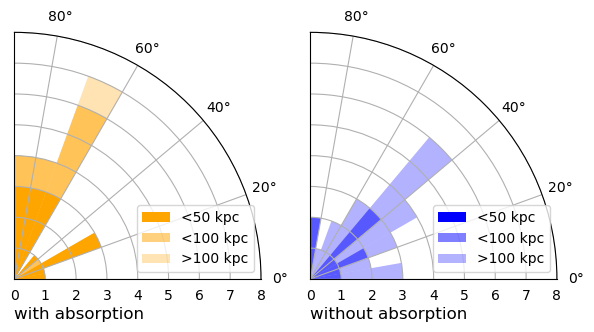

In [258]:
plt.figure(figsize = (7,5), dpi = 100)
plt.subplot(121, polar = True)
plt.hist(isol_incl_visu_rot_abs_50["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 1, color = "orange", label = "<50 kpc");
plt.hist(isol_incl_visu_rot_abs_100["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 0.5, color = "orange", label = "<100 kpc");
plt.hist(isol_incl_visu_rot_abs["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 0.3, color = "orange",label = ">100 kpc");
plt.legend(loc='lower right')
plt.text(3*np.pi/2, 1.3, "with absorption", size = 12)
plt.xlim((0,90*np.pi/180))
plt.ylim((0,8))
#plt.xlabel("$\\alpha$", size = 14)

plt.subplot(122, polar = True)
plt.hist(isol_incl_visu_rot_noabs_50["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 1, color = "blue", label = "<50 kpc");
plt.hist(isol_incl_visu_rot_noabs_100["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 0.5, color = "blue", label = "<100 kpc");
plt.hist(isol_incl_visu_rot_noabs["alpha"]*np.pi/180, range = (0,90*np.pi/180), bins = 9, alpha = 0.3, color = "blue",label = ">100 kpc");
#plt.hist(isol_incl_visu_rot_noabs["alpha"], alpha  = 0.5);
#plt.text(30, 7, "without absorption", size = 12)
plt.text(3*np.pi/2, 1.3, "without absorption", size = 12)
plt.legend(loc = "lower right")
plt.xlim((0,90*np.pi/180))
plt.ylim((0,8))
#plt.xlabel("$\\alpha$", size = 14)


In [259]:
def compute_alpha(R):
    
    THETA2 = []
    OP = []
    AD = []
    for i, r in R.iterrows():    
        ad = r["DEC"] - r["dec_qso"]
        op = (r["RA"] - r["ra_qso"])*np.cos(2*np.pi*r["DEC"]/360)
        #print(ad)
        theta = np.arctan(op/ad)
        theta = theta*360/2/np.pi
    
        if ((ad>=0) and (op>=0)):
            theta2 = theta
        elif ((ad<=0) and (op>=0)):
            theta2 = theta + 180
        elif ((ad<=0) and (op<=0)):
            theta2 = theta +180
        elif ((ad>=0) and (op<=0)):
            theta2 = theta+360

        theta2 = np.abs(theta2-360)
        THETA2.append(theta2)
        OP.append(op)
        AD.append(ad)
    #alpha = theta%180 - R["pa"]%180
    #alpha = (alpha - 90)%180 - 90
    #alpha = np.abs(alpha)
    #R["theta"] = theta
    R["theta2"] = np.array(THETA2)
    R["op"] = np.array(OP)
    R["ad"] = np.array(AD)
    R["alpha_360"] = (R["theta2"] + R["pa"])%360
    
    return R

In [260]:
isol_incl_visu_rot_abs = compute_alpha(isol_incl_visu_rot_abs)
isol_incl_visu_rot_noabs = compute_alpha(isol_incl_visu_rot_noabs)

closest_incl_visu_rot_abs = compute_alpha(closest_incl_visu_rot_abs)
closest_incl_visu_rot_noabs = compute_alpha(closest_incl_visu_rot_noabs)

/tmp/ipykernel_3781624/2115270849.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R["theta2"] = np.array(THETA2)
/tmp/ipykernel_3781624/2115270849.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R["op"] = np.array(OP)
/tmp/ipykernel_3781624/2115270849.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

(array([4., 4., 6., 2., 3., 4., 3., 5., 8., 9.]),
 array([  2.30270193,  19.82986899,  37.35703604,  54.8842031 ,
         72.41137016,  89.93853722, 107.46570428, 124.99287134,
        142.52003839, 160.04720545, 177.57437251]),
 <BarContainer object of 10 artists>)

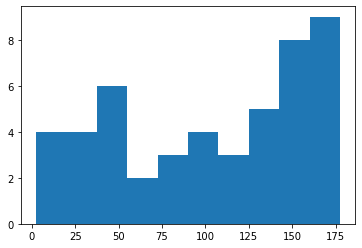

In [261]:
ad = isol_incl_visu_rot["dec_qso"] - isol_incl_visu_rot["DEC"]
op = (isol_incl_visu_rot["ra_qso"] - isol_incl_visu_rot["RA"])*np.cos(2*np.pi*isol_incl_visu_rot["DEC"]/360)

theta = np.arctan(op/ad)
theta = theta*360/2/np.pi

plt.hist(theta%180)

(array([9., 6., 2., 4., 5., 5., 4., 6., 6., 1.]),
 array([ 10.67418261,  27.14094557,  43.60770853,  60.0744715 ,
         76.54123446,  93.00799743, 109.47476039, 125.94152335,
        142.40828632, 158.87504928, 175.34181225]),
 <BarContainer object of 10 artists>)

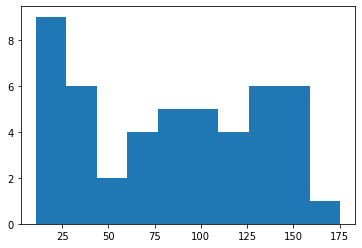

In [262]:
plt.hist(isol_incl_visu_rot["pa"]%180)

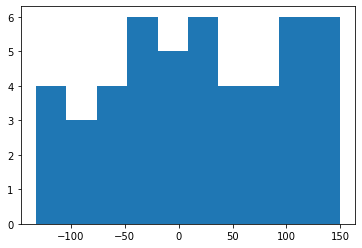

In [263]:
plt.hist(theta%180 - isol_incl_visu_rot["pa"]%180);

In [264]:
for c in isol_incl_visu_rot_noabs.columns:
    print(c)

_id
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)
PSF_qso
Comments_qso
zqso_sdss
depth_qso
ebv_sfd_qso
ebv_sandf_qso
ebv_planck_qso
HST_qs

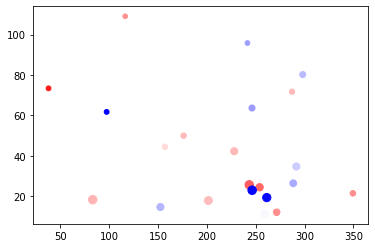

In [265]:
plt.scatter(isol_incl_visu_rot_abs["alpha_360"], isol_incl_visu_rot_abs["B_KPC"], \
               s = isol_incl_visu_rot_abs["REW_2796"]*20 +20, \
               c = const.c.value*(isol_incl_visu_rot_abs["z_absorption"] - isol_incl_visu_rot_abs["Z"])/(1+isol_incl_visu_rot_abs["Z"])/1e3,\
               vmin = -200, vmax = 200, cmap = "bwr")

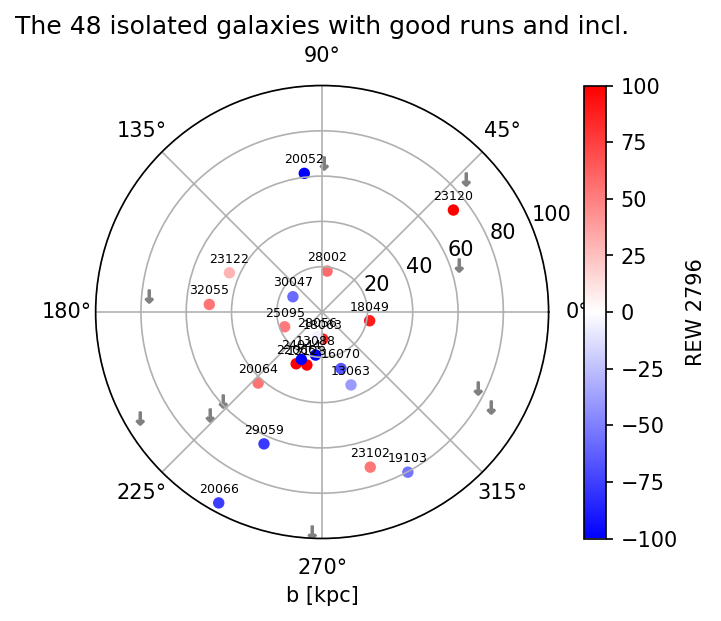

In [266]:

fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_visu_rot)) + " isolated galaxies with good runs and incl.", size = 12)

c = ax.scatter(isol_incl_visu_rot_abs["alpha_360"]*2*np.pi/360, isol_incl_visu_rot_abs["B_KPC"], \
               s = 20, \
               c = const.c.value*(isol_incl_visu_rot_abs["z_absorption"] - isol_incl_visu_rot_abs["Z"])/(1+isol_incl_visu_rot_abs["Z"])/1e3,\
               vmin = -100, vmax = 100, cmap = "bwr")
fig.colorbar(c, label = "REW 2796")
c2 = ax.scatter(isol_incl_visu_rot_noabs["alpha_360"]*2*np.pi/360, isol_incl_visu_rot_noabs["B_KPC"], \
                marker = "$\downarrow$", c = "grey")
plt.xlim((0,360*2*np.pi/360))
plt.xlabel("b [kpc]")
plt.ylim((0,100))


for i, g in isol_incl_visu_rot_abs.iterrows():
    plt.annotate(g["ID"], (g["alpha_360"]*2*np.pi/360, g["B_KPC"]), textcoords="offset points",\
                 xytext=(0,5), ha='center', size = 6)

(0.0, 170.0)

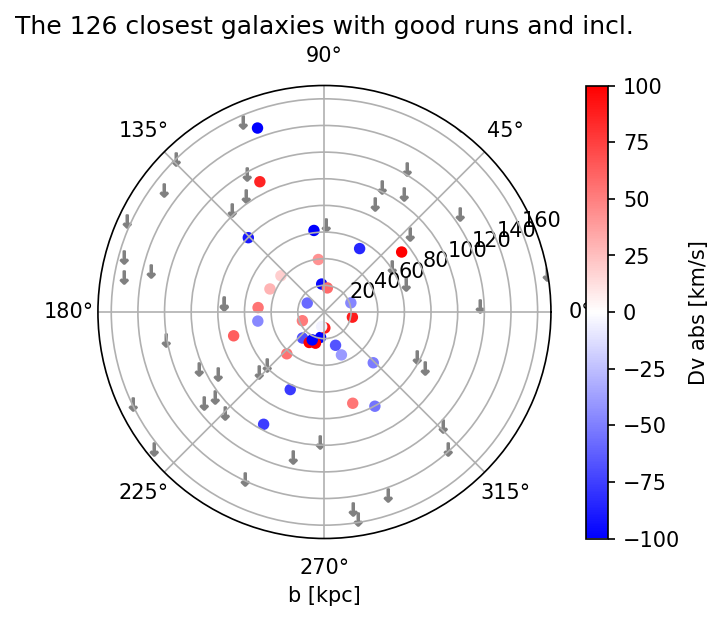

In [267]:

fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(closest_incl_visu_rot)) + " closest galaxies with good runs and incl.", size = 12)

c = ax.scatter(closest_incl_visu_rot_abs["alpha_360"]*2*np.pi/360, closest_incl_visu_rot_abs["B_KPC"], \
               #s = closest_incl_visu_rot_abs["REW_2796"]*20 +20, \
               s = 20,\
               c = const.c.value*(closest_incl_visu_rot_abs["z_absorption"] - closest_incl_visu_rot_abs["Z"])/(1+closest_incl_visu_rot_abs["Z"])/1e3,\
               vmin = -100, vmax = 100, cmap = "bwr")
fig.colorbar(c, label = "Dv abs [km/s]")
c2 = ax.scatter(closest_incl_visu_rot_noabs["alpha_360"]*2*np.pi/360, closest_incl_visu_rot_noabs["B_KPC"], \
                marker = "$\downarrow$", c = "grey")
plt.xlim((0,360*2*np.pi/360))
plt.xlabel("b [kpc]")
plt.ylim((0,170))

(array([2., 2., 4., 1., 1., 0., 6., 3., 3.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <BarContainer object of 9 artists>)

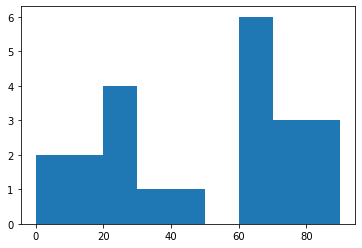

In [268]:
plt.hist(isol_incl_visu_rot_abs["alpha_360"]%90, bins = 9, range = (0,90))

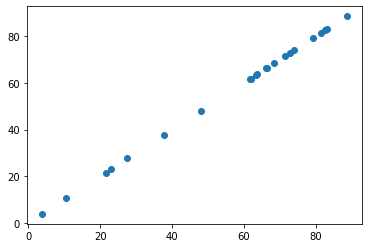

In [269]:
plt.scatter(isol_incl_visu_rot_abs["alpha"], (90 - np.abs(np.abs(isol_incl_visu_rot_abs["alpha_360"]- 180) - 90)))

(array([1., 1., 3., 1., 1., 0., 7., 4., 4.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <BarContainer object of 9 artists>)

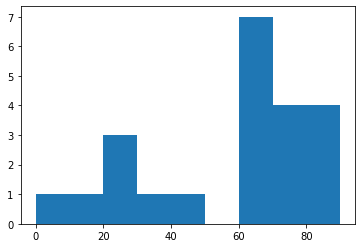

In [270]:
plt.hist((90 - np.abs(np.abs(isol_incl_visu_rot_abs["alpha_360"]- 180) - 90)), bins = 9, range = (0,90))

**THINGS ARE CONSISTENT!!!**

(array([2., 1., 2., 1., 1., 0., 7., 3., 5.]),
 array([ 3.81817739, 13.23218826, 22.64619914, 32.06021002, 41.47422089,
        50.88823177, 60.30224265, 69.71625352, 79.1302644 , 88.54427528]),
 <BarContainer object of 9 artists>)

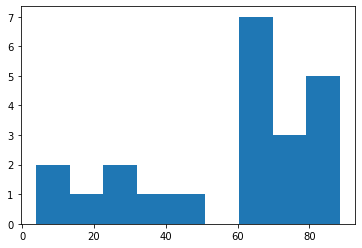

In [271]:
plt.hist(isol_incl_visu_rot_abs["alpha"],bins = 9)

In [272]:
len(isol_incl_visu_rot_abs)

22

3.8968159 -7.8495916
3.8965362 -7.8501674
3.8972148 -7.8500011


14.7345983 1.1884654
22.9024317 13.0593182
26.3053104 10.9413341


26.3050614 10.940672
120.0162024 18.8271134
129.7174933 2.9490644


129.7155396 2.951144
129.7198903 2.9517329
159.9035011 7.2403609


166.9298816 10.3553288
166.9270769 10.3594524
166.9279681 10.3587895


166.8973704 17.9581183
189.1010706 7.4307398
209.5389281 11.7663379


/tmp/ipykernel_3781624/2244943523.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (7,7))


209.5393673 11.7656439
216.4083337 12.1575468
227.2504071 15.1101399


328.001526 6.422173


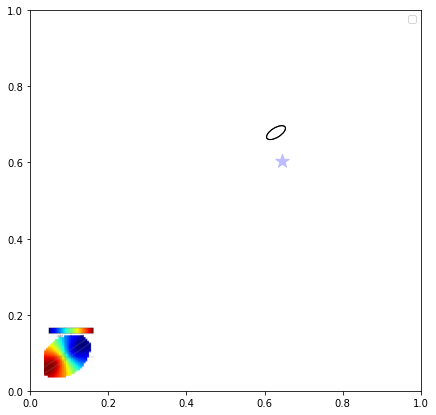

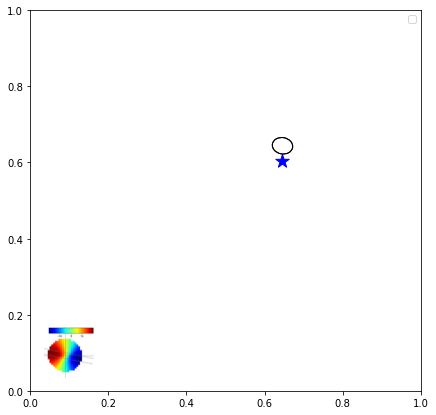

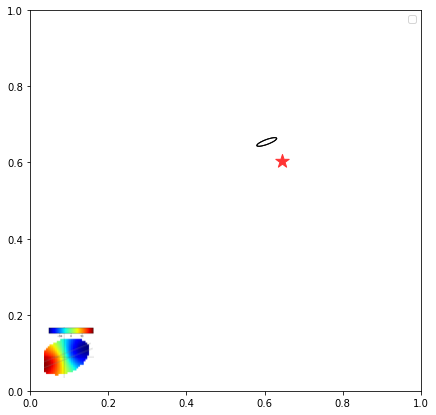

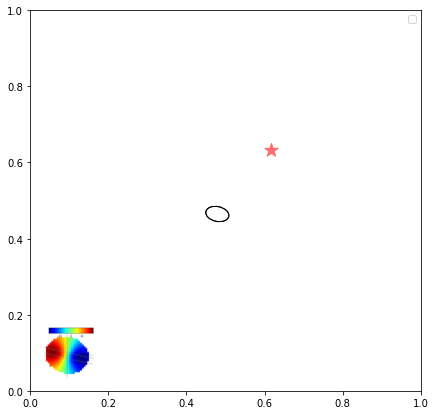

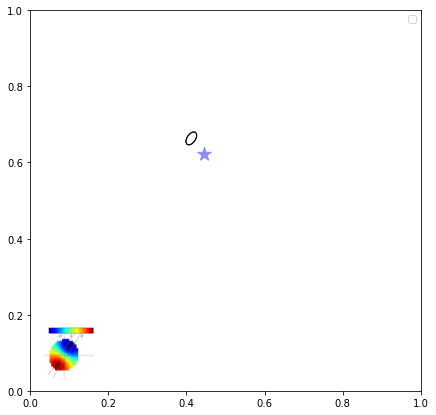

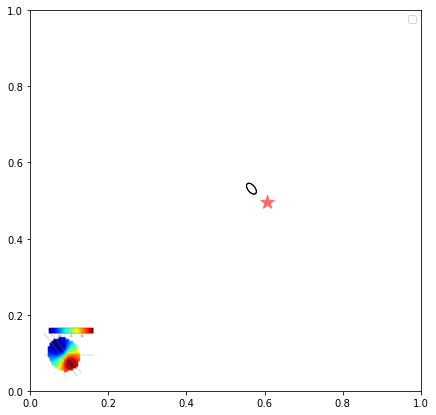

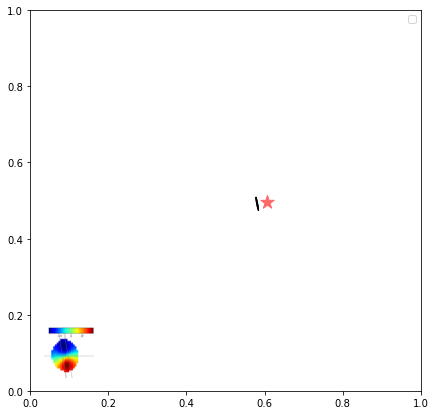

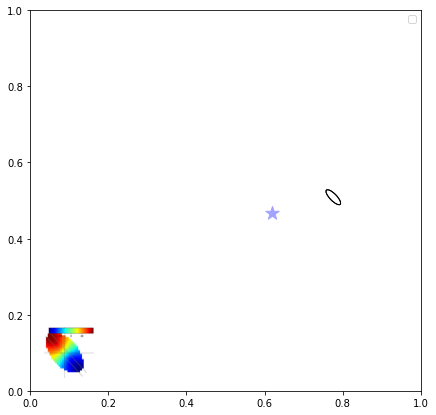

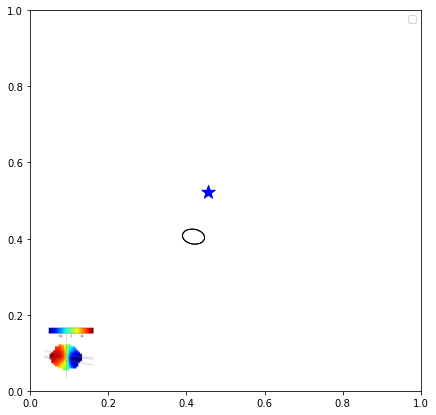

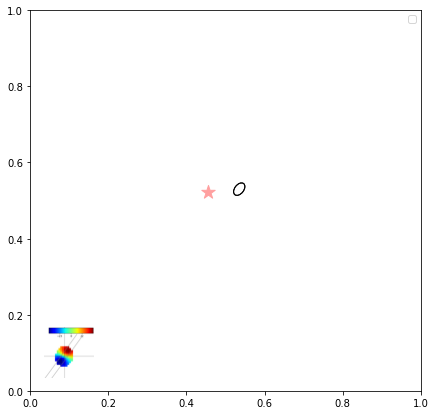

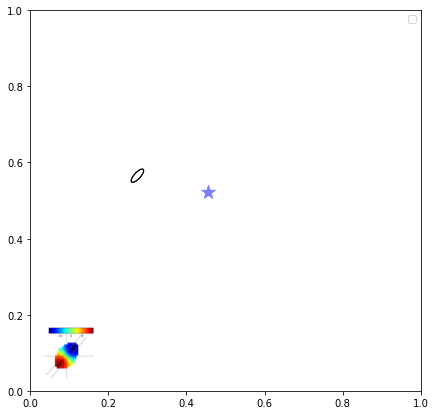

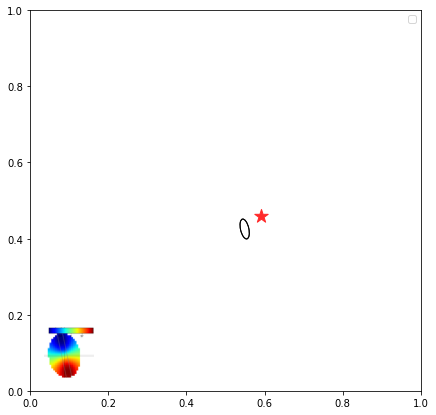

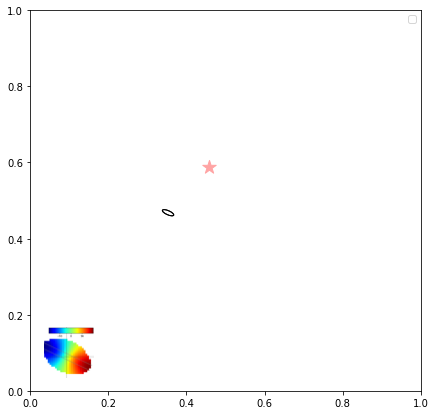

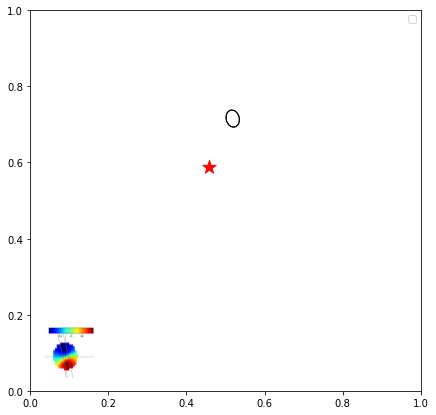

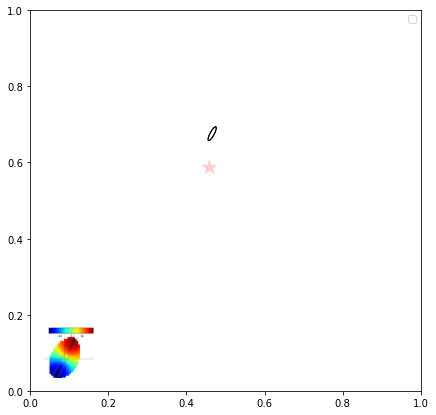

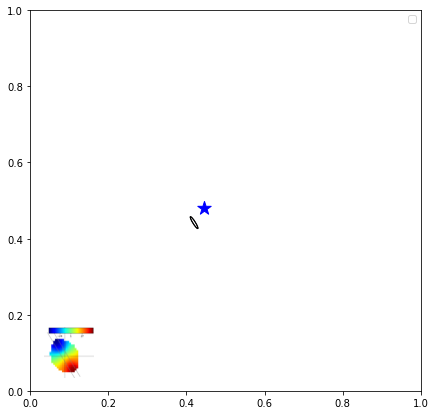

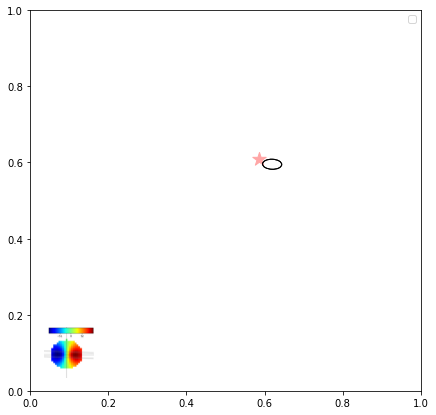

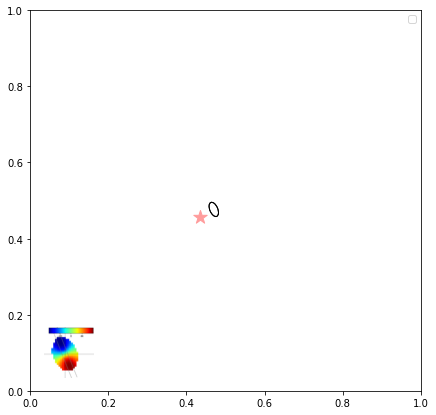

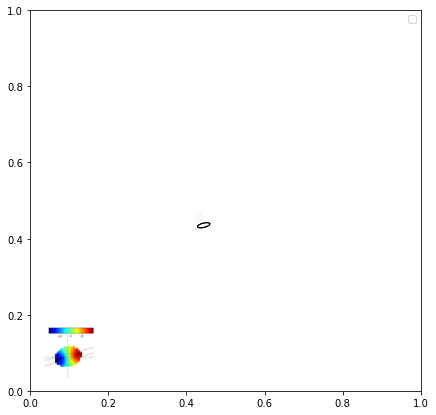

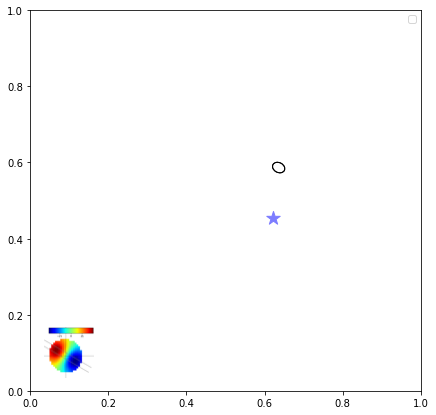

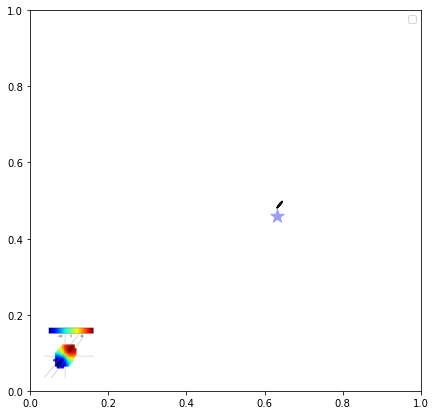

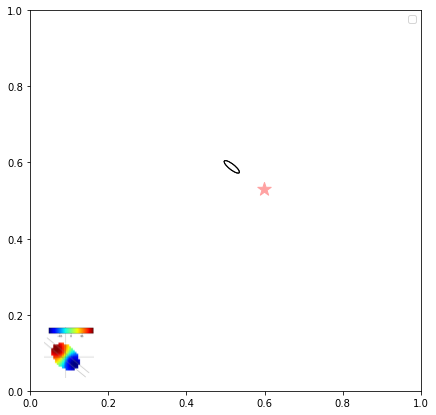

In [273]:
dir = "/muse/MG2QSO/private/production_dr2/"
for i, r in isol_incl_visu_rot_abs.iterrows():
    field_id = r["field_id"]
    src_id = r["ID"] 
    run_name = r["run_name"]
    z_src = r["Z"]
    REW2796 =r["REW_2796"]
    B_KPC = r["B_KPC"]
    incl = r["inclination"]
    alpha = r["alpha"]
    pa = r["pa"]
    radius = r["radius"]
    snr_eff = r["snr_eff"]
    #score = r["galpak_score"]
    #score_auto = r["score_auto"]
    #primary = r["primary"]
    primary_auto = r["primary_auto"]
    isolated_auto = r["isolated_auto"]
    mass = r["sed_logMass"]
    logSFR = np.log10(r["SFR_gilbank"])
    z = r["Z"]
    
       
    ymin = 0
    ymax = 300
    xmin = 0
    xmax = 300
    massmin = 9
    massmax = 12
    ss_min = 0.02
    ss_max = 0.1
    vmin = -0.5
    vmax = 1.2
    
    field_cube_path = dir + field_id +"/" + field_id +"_dr2_zap.fits"
    cube = Cube(field_cube_path)
    #ima_wli = cube.sum(axis=0)
    
    pixcoord = cube.wcs.sky2pix([r["DEC"], r["RA"]])[0]
    decpix = pixcoord[0]
    rapix = pixcoord[1]
    qso_pixcoord = cube.wcs.sky2pix([r["dec_qso"], r["ra_qso"]])[0]
    qso_decpix = qso_pixcoord[0]
    qso_rapix = qso_pixcoord[1]
    
    print(r["RA"], r["DEC"])
    
    xx = (rapix - xmin)/(xmax - xmin)
    yy = (decpix - ymin)/(ymax - ymin)
    qso_xx = (qso_rapix - xmin)/(xmax - xmin)
    qso_yy = (qso_decpix - ymin)/(ymax - ymin)
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    #w = 20
    #h = 10
    
    #plt.figure(figsize = (7,7))

    
    fig, ax = plt.subplots(figsize = (7,7))
    #print(r["Z"], r["z_absorption"])
    dv = const.c.value*(r["z_absorption"] - r["Z"])/(1+r["Z"])/1e3
    Brvir = np.round(r["B_KPC"]/r["Rvir"], 3)
    #label = "theta = " + str(np.round(r["theta"])) + \
    #"  op = " + str(np.round(r["op"], 5)) + \
    #"  ad = " + str(np.round(r["ad"], 5)) + \
    #"  theta2 = " + str(np.round(r["theta2"])) + \
    #"  pa = " + str(np.round(r["pa"])) + \
    #"  alpha = " + str(np.round(r["alpha"])) + \
    #"  alpha360 = "+ str(np.round(r["alpha_360"]))
    ax.scatter(qso_xx, qso_yy, marker = "*", c = dv, cmap = "bwr", vmin = -150, vmax = 150, s = 200)
    
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=pa+90,fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
        #plt.scatter(xx, yy)
    else:
        ax.scatter(xx, yy)
    
    run_dir = "/muse/MG2QSO/private/analysis/galpak_dr2/"
    run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"
    img = Image.open(run_path + "run_obs_maps.png")
    img = img.crop((500, 80, 700 , 280))
    img.thumbnail((50, 50))  # Redimensionnement de l'image
    imagebox = OffsetImage(img)
    
    ab = AnnotationBbox(imagebox, (0.1, 0.1), frameon=False)
    ax.add_artist(ab)
    label = "pa = " + str(np.round(r["pa"])) + "\n"+\
            "alpha = "+ str(np.round(r["alpha"]))
    
    #plt.patches.Ellipse((rapix, decpix),10, 3)
    #matplotlib.patches.Ellipse((rapix, decpix),10, 3)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.legend()

In [346]:
isol_9.head(3)

,_id,ID,field_id,DATASET,FROM,Z,ZCONF,is_QSO,is_star,DR1_id,...,run_convergence_global,is_not_cont_run,is_multinest,minus_chi2_at_p,minus_BIC,logSFR,logSSFR,v_sig,isolation_dist,Rfov
74,0,11097,J0014m0028,b'psfsub',b'FELINE',0.40815,3,0,0,NaN,...,1.0,True,True,-0.624132,-18718.0,-0.451973,-9.653573,6.324798,165.682191,165.412798
94,0,11117,J0014m0028,b'psfsub',b'FELINE',0.95172,3,0,0,NaN,...,1.0,True,True,-0.511879,-15376.0,0.273306,-8.783540,2.759982,126.829563,241.520605
230,0,12108,J0014p0912,b'psfsub',b'FELINE',0.60386,3,0,0,NaN,...,1.0,True,True,-0.496520,-14918.0,0.823932,-8.879242,6.264745,149.631227,204.249197


est-ce que regarder la fc en fonction de log(b) ou de b est équivalent et revient juste à un changement de variable?
Actuellement on fit la fontion logistique sur log(b):
\begin{equation}
    fc = \frac{1}{1 + \exp(-(k_1(\log(b) - k_0))}
\end{equation}

Dans l'absolu, je pense qu'il vaudrait mieux fitter la fc directement su b au lieu de log(b), càd: 

\begin{equation}
    fc = \frac{1}{1 + \exp(-(k_1(b - k_0))}
\end{equation}

**Les deux formes ne sont PAS équivalentes!**



In [849]:
def fc_shape(x, k0, k1):
    t = k1*(x - k0)
    return 1/(1 + np.exp(-t))

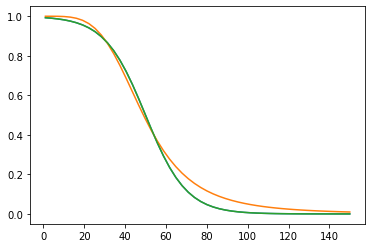

In [891]:
xx = np.linspace(1, 150)
logxx = np.log10(xx)
k0, k1 = 50, -0.1
k0_2, k1_2 = 1.69, -9.5

plt.plot(xx, fc_shape(xx, k0, k1))
plt.plot(10**logxx, fc_shape(logxx, k0_2, k1_2))
plt.plot(10**logxx, fc_shape(10**logxx, k0, k1))

### multiple parameters fit

\begin{equation}
    log(W) = a_0 + a_1.b + a_2.log(1+z) + a_3.log(SFR) + a_4.log(M^*)
\end{equation}

Pour calculer l'interval d'erreur sur la W = 0.1 en fonction de b par exemple:

\begin{equation}
    b = \frac{log(W) - a_0 - a_2.log(1+z) - a_3.log(SFR) - a_4.log(M^*)}{a_1}
\end{equation}

les dérivées partielles sont:

\begin{equation}
    \frac{\partial b}{\partial a_0} = -\frac{1}{a_1}
\end{equation}
\begin{equation}
    \frac{\partial b}{\partial a_1} = -\frac{b}{a_1}
\end{equation}
\begin{equation}
    \frac{\partial b}{\partial a_2} = -\frac{log(1+z)}{a_1}
\end{equation}
\begin{equation}
    \frac{\partial b}{\partial a_3} = -\frac{log(SFR)}{a_1}
\end{equation}
\begin{equation}
    \frac{\partial b}{\partial a_4} = -\frac{log(M*)}{a_1}
\end{equation}

Donc finalement:

\begin{equation}
    \sigma_b = \frac{-\sigma_{a_0} - b \sigma_{a_1} - \sigma_{a_2} log(1+z) - \sigma_{a_3} log(SFR) - \sigma_{a_4} log(M^*)}{a_1}
\end{equation}

In [899]:
x1 = np.array([isol_abs["B_KPC"], np.log10(1+isol_abs["Z"]), isol_abs["logSFR"], isol_abs["sed_logMass"]])
x2 = np.array([isol_noabs["B_KPC"], np.log10(1+isol_noabs["Z"]), isol_noabs["logSFR"], isol_noabs["sed_logMass"]])
y1 = np.array(np.log10(isol_abs["REW_2796"]))
y2 = np.array(np.log10(isol_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_abs["sig_REW_2796"]/isol_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [900]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([-1, -1, 2, 0, 0.1, 0.5]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2))
fit_multi_1sig = np.diag(fit_multi.hess_inv)**0.5
fit_multi_1sig_inf = fit_multi['x'] - fit_multi_1sig
fit_multi_1sig_sup = fit_multi['x'] + fit_multi_1sig
fit_multi

      fun: 75.05960320695847
 hess_inv: array([[ 1.22606507e-01,  2.14413302e-05, -2.47041637e-01,
         5.22029250e-03, -5.73877242e-03, -2.91571305e-03],
       [ 2.14413302e-05,  6.13655706e-06, -3.57691683e-05,
         4.67647092e-05, -3.63024042e-05, -7.66135796e-05],
       [-2.47041637e-01, -3.57691683e-05,  5.36278572e-01,
        -2.51155804e-02,  1.10903071e-02, -2.98327271e-03],
       [ 5.22029250e-03,  4.67647092e-05, -2.51155804e-02,
         6.93852978e-03, -2.65591640e-04,  9.70038009e-04],
       [-5.73877242e-03, -3.63024042e-05,  1.10903071e-02,
        -2.65591640e-04,  5.73946188e-04,  4.17051718e-04],
       [-2.91571305e-03, -7.66135796e-05, -2.98327271e-03,
         9.70038009e-04,  4.17051718e-04,  6.61079342e-03]])
      jac: array([9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 441
      nit: 49
     njev: 63
   status: 0
  success: True


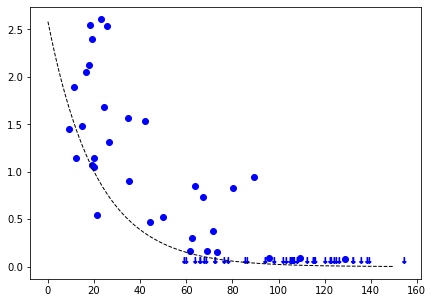

In [901]:
plt.figure(figsize = (7,5))
B_arr = np.linspace(0, 150, 200)
z_arr = np.log10(np.linspace(1, 1, 200)+1)
sfr_arr = np.linspace(0.5, 0.5, 200)
m_arr = np.linspace(9.8, 9.8, 200)
X = np.array([B_arr, z_arr, sfr_arr, m_arr])
plt.plot(B_arr, 10**gt.model_multi(fit_multi['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "$\log(M_*/M_{\odot})$>9")
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")

In [902]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
bb01_z, sig01_z = gt.predict_b(fit_multi, z = zz, sfr = 0, logm = 9, rew = 0.1)
bb01_sfr, sig01_sfr = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = sfr, logm = 9, rew = 0.1)
bb01_m, sig01_m = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = 0, logm = logm, rew = 0.1)

In [903]:
fc_z = pd.read_csv("fc_z.csv", index_col = False)
fc_sfr = pd.read_csv("fc_sfr.csv", index_col = False)
fc_m = pd.read_csv("fc_m.csv", index_col = False)

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

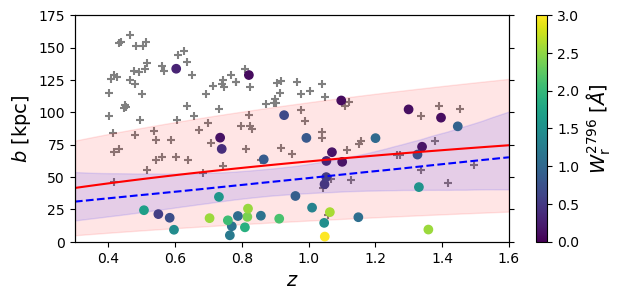

In [904]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_abs["Z"], isol_abs["B_KPC"], c = isol_abs["REW_2796"],\
            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
#cbar = plt.colorbar(im, ax=ax1, location='right', shrink=1, pad=0.1)
#cbar.set_label('Colorbar Label')
#ax1.colorbar(label = "$W^{2796}_{\mathrm{r}}$")
ax1.scatter(isol_noabs["Z"], isol_noabs["B_KPC"], c = "grey",\
             marker = "+", vmin = 0, vmax = 3, alpha = 1)
ax1.plot(10**zz-1, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(10**zz-1, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_z["z"]), np.array(fc_z["pbest"]), color = "blue", \
         linestyle = "--", label = "fc($0.1 \AA$) = 50%")
ax1.fill_between(np.array(fc_z["z"]), np.array(fc_z["plow"]), np.array(fc_z["phigh"]), color = "blue", alpha = 0.1)


ax2 = ax1.twinx()
ax1.set_xlim((0.3, 1.6))
ax1.set_ylim((0., 175))
ax2.set_ylim((0., 175))
ax1.set_ylabel("$b$ [kpc]", size = 14)
ax1.set_xlabel("$z$", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper right', fontsize = 12)
#ax2.legend(loc='upper right')

#plt.axhline(0.5, c = "r")
#plt.legend()

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

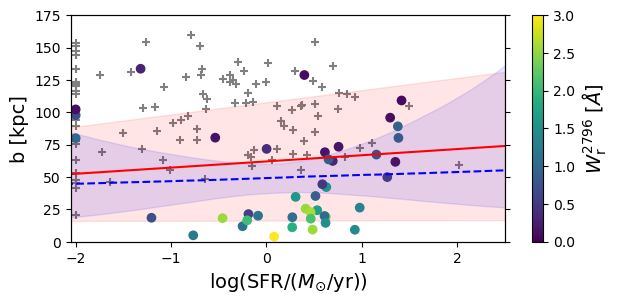

In [905]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_abs["logSFR"], isol_abs["B_KPC"], c = isol_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_noabs["logSFR"], isol_noabs["B_KPC"], c = "grey",\
             marker = "+", vmin = 0, vmax = 3, alpha = 1)
ax1.plot(sfr, bb01_sfr, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(sfr, bb01_sfr - sig01_sfr, bb01_sfr + sig01_sfr, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["plow"]), np.array(fc_sfr["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((-2.05, 2.5))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(SFR/($M_{\odot}$/yr))", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper left')
#plt.axhline(0.5, c = "r")

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

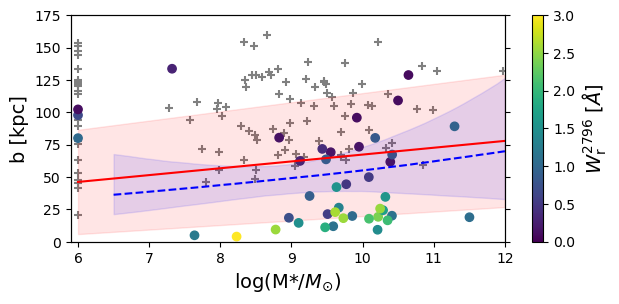

In [906]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
ax1.scatter(isol_abs["sed_logMass"], isol_abs["B_KPC"], c = isol_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_noabs["sed_logMass"], isol_noabs["B_KPC"], c = "grey",\
             marker = "+", vmin = 0, vmax = 3, alpha = 1)
ax1.plot(logm, bb01_m, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(logm, bb01_m - sig01_m, bb01_m + sig01_m, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_m["logm"]), np.array(fc_m["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_m["logm"]), np.array(fc_m["plow"]), np.array(fc_m["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((5.9, 12))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(M*/$M_{\odot}$)", size = 14)
ax2.yaxis.set_ticklabels([])
#plt.axhline(0.5, c = "r")

### multi fit, only with sample A

In [1094]:
x1 = np.array([isol_9_abs["B_KPC"], np.log10(1+ isol_9_abs["Z"]), isol_9_abs["logSFR"], isol_9_abs["sed_logMass"]])
#x1 = np.array([isol_9_abs["B_KPC"], isol_9_abs["Z"], isol_9_abs["logSFR"], isol_9_abs["sed_logMass"]])
x2 = np.array([isol_9_noabs["B_KPC"], np.log10(1+isol_9_noabs["Z"]), isol_9_noabs["logSFR"], isol_9_noabs["sed_logMass"]])
#x2 = np.array([isol_9_noabs["B_KPC"], isol_9_noabs["Z"], isol_9_noabs["logSFR"], isol_9_noabs["sed_logMass"]])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [1095]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([-2, -0., 2, 2, 0., 0.]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi_1sig = np.diag(fit_multi.hess_inv)**0.5
fit_multi_1sig_inf = fit_multi['x'] - fit_multi_1sig
fit_multi_1sig_sup = fit_multi['x'] + fit_multi_1sig
fit_multi

      fun: 34.13774031440366
 hess_inv: array([[ 1.57414553e+00,  1.28969517e-04, -4.57280471e-01,
         7.16183942e-02, -1.49180260e-01, -2.06103147e-03],
       [ 1.28969517e-04,  5.70421623e-06, -6.35836514e-04,
        -8.34708549e-05, -1.74124750e-05, -5.03734284e-05],
       [-4.57280471e-01, -6.35836514e-04,  1.95466793e+00,
        -1.01866864e-01, -1.43819200e-03,  5.59124287e-03],
       [ 7.16183942e-02, -8.34708549e-05, -1.01866864e-01,
         2.56136901e-02, -5.30954938e-03,  4.06054609e-04],
       [-1.49180260e-01, -1.74124750e-05, -1.43819200e-03,
        -5.30954938e-03,  1.54111868e-02,  1.28781605e-04],
       [-2.06103147e-03, -5.03734284e-05,  5.59124287e-03,
         4.06054609e-04,  1.28781605e-04,  3.73025684e-03]])
      jac: array([ 0.00000000e+00,  9.53674316e-06,  0.00000000e+00,  0.00000000e+00,
        3.33786011e-06, -4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 742
      nit: 98
     njev: 106
   status: 0
  success

In [1096]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
#zz = np.linspace(0.3, 1.6, 100)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [zz, 0, 9]
bb01_z, sig01_z = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_z, sig01_z = gt.predict_b(fit_multi, z = zz, sfr = 0, logm = 9, rew = 0.1)
eval_at = [np.log10(1+1), sfr, 9]
#eval_at = [1+1, sfr, 9]
bb01_sfr, sig01_sfr = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_sfr, sig01_sfr = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = sfr, logm = 9, rew = 0.1)
eval_at = [np.log10(1+1), 0, logm]
#eval_at = [1+1, 0, logm]
bb01_m, sig01_m = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_m, sig01_m = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = 0, logm = logm, rew = 0.1)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [1091]:
len(fit_multi['x'])

6

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

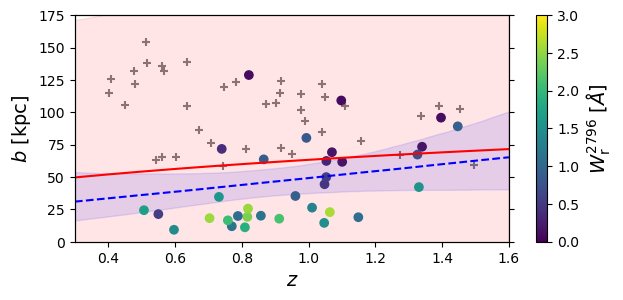

In [1097]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["Z"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
#cbar = plt.colorbar(im, ax=ax1, location='right', shrink=1, pad=0.1)
#cbar.set_label('Colorbar Label')
#ax1.colorbar(label = "$W^{2796}_{\mathrm{r}}$")
ax1.scatter(isol_9_noabs["Z"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(10**zz-1, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#ax1.plot(zz, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(10**zz-1, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
#ax1.fill_between(zz, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_z["z"]), np.array(fc_z["pbest"]), color = "blue", \
         linestyle = "--", label = "fc($0.1 \AA$) = 50%")
ax1.fill_between(np.array(fc_z["z"]), np.array(fc_z["plow"]), np.array(fc_z["phigh"]), color = "blue", alpha = 0.1)


ax2 = ax1.twinx()
ax1.set_xlim((0.3, 1.6))
ax1.set_ylim((0., 175))
ax2.set_ylim((0., 175))
ax1.set_ylabel("$b$ [kpc]", size = 14)
ax1.set_xlabel("$z$", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper right', fontsize = 12)
#ax2.legend(loc='upper right')

#plt.axhline(0.5, c = "r")
#plt.legend()

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

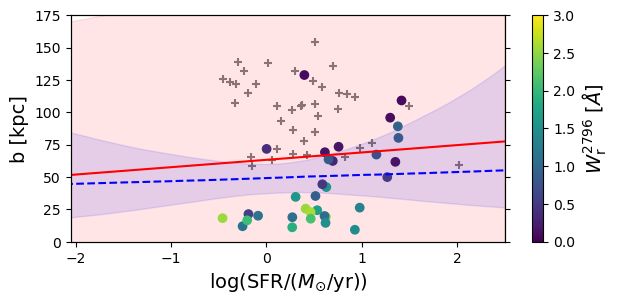

In [1098]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["logSFR"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["logSFR"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(sfr, bb01_sfr, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(sfr, bb01_sfr - sig01_sfr, bb01_sfr + sig01_sfr, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["plow"]), np.array(fc_sfr["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((-2.05, 2.5))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(SFR/($M_{\odot}$/yr))", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper left')
#plt.axhline(0.5, c = "r")

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

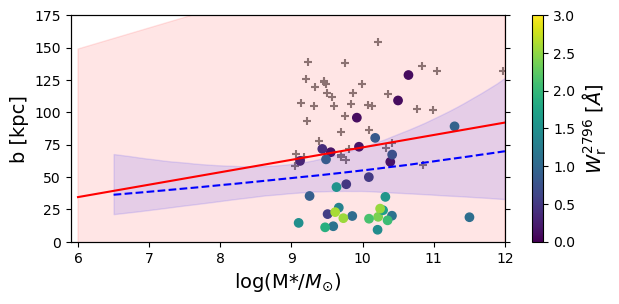

In [1099]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
ax1.scatter(isol_9_abs["sed_logMass"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["sed_logMass"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", vmin = 0, vmax = 3, alpha = 1)
ax1.plot(logm, bb01_m, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(logm, bb01_m - sig01_m, bb01_m + sig01_m, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_m["logm"]), np.array(fc_m["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_m["logm"]), np.array(fc_m["plow"]), np.array(fc_m["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((5.9, 12))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(M*/$M_{\odot}$)", size = 14)
ax2.yaxis.set_ticklabels([])
#plt.axhline(0.5, c = "r")

# Fitting parameters 1 by 1

### Only as a function of z

In [997]:
x1 = np.array([isol_9_abs["B_KPC"], np.log10(1+ isol_9_abs["Z"])])
x2 = np.array([isol_9_noabs["B_KPC"], np.log10(1+isol_9_noabs["Z"])])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [1004]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([-0.1, -0.3, 0, 1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi_1sig = np.diag(fit_multi.hess_inv)**0.5
fit_multi_1sig_inf = fit_multi['x'] - fit_multi_1sig
fit_multi_1sig_sup = fit_multi['x'] + fit_multi_1sig
fit_multi

      fun: 36.379061965130944
 hess_inv: array([[ 1.12211959e-01,  6.89677911e-05, -3.84399677e-01,
        -3.40247037e-03],
       [ 6.89677911e-05,  5.64468550e-06, -1.25592024e-03,
        -5.43203697e-05],
       [-3.84399677e-01, -1.25592024e-03,  1.56542528e+00,
         1.59238897e-02],
       [-3.40247037e-03, -5.43203697e-05,  1.59238897e-02,
         4.01744955e-03]])
      jac: array([ 0.00000000e+00, -9.53674316e-07,  0.00000000e+00,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 170
      nit: 26
     njev: 34
   status: 0
  success: True
        x: array([-0.13763382, -0.0217147 ,  2.6198014 ,  0.45625795])

In [1005]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [zz]
bb01_z, sig01_z = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_z, sig01_z = gt.predict_b(fit_multi, z = zz, sfr = 0, logm = 9, rew = 0.1)

In [1006]:
len(fit_multi['x'])

4

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

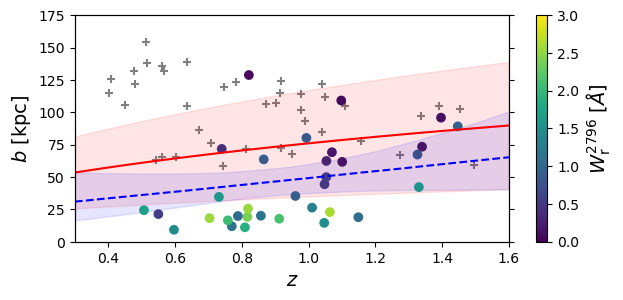

In [1007]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["Z"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
#cbar = plt.colorbar(im, ax=ax1, location='right', shrink=1, pad=0.1)
#cbar.set_label('Colorbar Label')
#ax1.colorbar(label = "$W^{2796}_{\mathrm{r}}$")
ax1.scatter(isol_9_noabs["Z"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(10**zz-1, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(10**zz-1, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_z["z"]), np.array(fc_z["pbest"]), color = "blue", \
         linestyle = "--", label = "fc($0.1 \AA$) = 50%")
ax1.fill_between(np.array(fc_z["z"]), np.array(fc_z["plow"]), np.array(fc_z["phigh"]), color = "blue", alpha = 0.1)


ax2 = ax1.twinx()
ax1.set_xlim((0.3, 1.6))
ax1.set_ylim((0., 175))
ax2.set_ylim((0., 175))
ax1.set_ylabel("$b$ [kpc]", size = 14)
ax1.set_xlabel("$z$", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper right', fontsize = 12)
#ax2.legend(loc='upper right')

#plt.axhline(0.5, c = "r")
#plt.legend()

### Only as a function of SFR

In [1008]:
x1 = np.array([isol_9_abs["B_KPC"], isol_9_abs["logSFR"]])
x2 = np.array([isol_9_noabs["B_KPC"], isol_9_noabs["logSFR"]])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [1015]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([-0.4, -0., 2, 0.5]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi_1sig = np.diag(fit_multi.hess_inv)**0.5
fit_multi_1sig_inf = fit_multi['x'] - fit_multi_1sig
fit_multi_1sig_sup = fit_multi['x'] + fit_multi_1sig
fit_multi

      fun: 36.128850141662454
 hess_inv: array([[ 1.90263594e-02, -2.01708557e-04, -6.08201233e-03,
         3.70384837e-04],
       [-2.01708557e-04,  5.20184727e-06, -1.06136740e-04,
        -4.75102172e-05],
       [-6.08201233e-03, -1.06136740e-04,  1.98880221e-02,
         8.34111638e-04],
       [ 3.70384837e-04, -4.75102172e-05,  8.34111638e-04,
         3.83722542e-03]])
      jac: array([-9.53674316e-07, -9.53674316e-06, -9.53674316e-07, -2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 19
     njev: 28
   status: 0
  success: True
        x: array([ 0.44786441, -0.02183491,  0.30222629,  0.45622852])

In [1017]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [sfr]
bb01_sfr, sig01_sfr = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_sfr, sig01_sfr = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = sfr, logm = 9, rew = 0.1)

In [1018]:
len(fit_multi['x'])

4

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

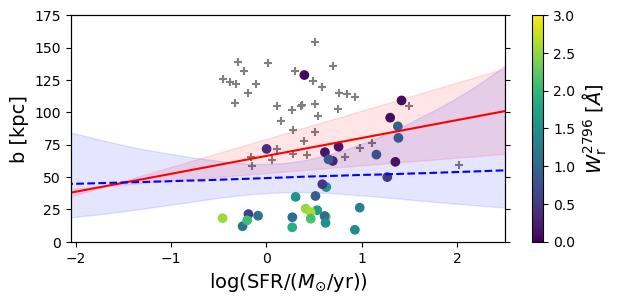

In [1019]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["logSFR"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["logSFR"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(sfr, bb01_sfr, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(sfr, bb01_sfr - sig01_sfr, bb01_sfr + sig01_sfr, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["plow"]), np.array(fc_sfr["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((-2.05, 2.5))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(SFR/($M_{\odot}$/yr))", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper left')
#plt.axhline(0.5, c = "r")

### Only as a function of M*

In [1040]:
x1 = np.array([isol_9_abs["B_KPC"], isol_9_abs["sed_logMass"]])
x2 = np.array([isol_9_noabs["B_KPC"], isol_9_noabs["sed_logMass"]])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [1041]:
fit_multi = minimize(gt.logL_stats_total_multi, np.array([-1, 0.4, 1, 0.8]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi_1sig = np.diag(fit_multi.hess_inv)**0.5
fit_multi_1sig_inf = fit_multi['x'] - fit_multi_1sig
fit_multi_1sig_sup = fit_multi['x'] + fit_multi_1sig
fit_multi

      fun: 36.05793905622845
 hess_inv: array([[ 1.08828143e+00,  2.38922373e-04, -1.09914728e-01,
        -5.54950217e-03],
       [ 2.38922373e-04,  4.13091122e-06, -4.53404629e-05,
        -4.78954110e-05],
       [-1.09914728e-01, -4.53404629e-05,  1.12593803e-02,
         6.59797181e-04],
       [-5.54950217e-03, -4.78954110e-05,  6.59797181e-04,
         3.54214395e-03]])
      jac: array([0.00000000e+00, 3.81469727e-06, 9.53674316e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 260
      nit: 42
     njev: 52
   status: 0
  success: True
        x: array([-2.05684434, -0.02087146,  0.26386803,  0.44411929])

In [1042]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [logm]
bb01_m, sig01_m = gt.predict_b(fit_multi, eval_at = eval_at, rew = 0.1)
#bb01_m, sig01_m = gt.predict_b(fit_multi, z = np.log10(1+1), sfr = 0, logm = logm, rew = 0.1)

In [1043]:
len(fit_multi['x'])

4

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

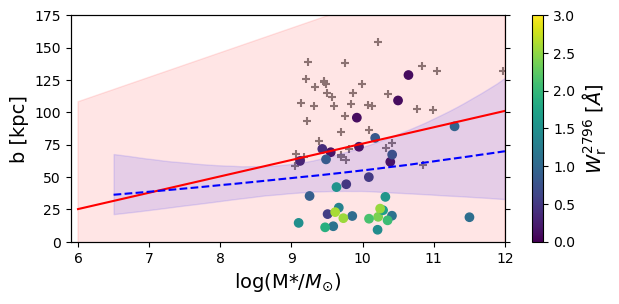

In [1044]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
ax1.scatter(isol_9_abs["sed_logMass"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["sed_logMass"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", vmin = 0, vmax = 3, alpha = 1)
ax1.plot(logm, bb01_m, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(logm, bb01_m - sig01_m, bb01_m + sig01_m, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_m["logm"]), np.array(fc_m["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_m["logm"]), np.array(fc_m["plow"]), np.array(fc_m["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((5.9, 12))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(M*/$M_{\odot}$)", size = 14)
ax2.yaxis.set_ticklabels([])
#plt.axhline(0.5, c = "r")

# Fitting W = f(SFR, z) not M*

In [1064]:
x1 = np.array([isol_9_abs["B_KPC"], np.log10(1+ isol_9_abs["Z"]), isol_9_abs["logSFR"]])
x2 = np.array([isol_9_noabs["B_KPC"], np.log10(1+isol_9_noabs["Z"]), isol_9_noabs["logSFR"]])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [1065]:
fit_multi2 = minimize(gt.logL_stats_total_multi, np.array([-2, -0., 2, 2, 0.]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi2_1sig = np.diag(fit_multi2.hess_inv)**0.5
fit_multi2_1sig_inf = fit_multi2['x'] - fit_multi2_1sig
fit_multi2_1sig_sup = fit_multi2['x'] + fit_multi2_1sig
fit_multi2

      fun: 35.52642655442773
 hess_inv: array([[ 1.45550725e-01, -4.32497218e-05, -5.27012517e-01,
         2.32242706e-02, -1.16297944e-03],
       [-4.32497218e-05,  5.83664971e-06, -7.05706747e-04,
        -8.33775606e-05, -5.78550946e-05],
       [-5.27012517e-01, -7.05706747e-04,  2.19493248e+00,
        -1.18808379e-01,  7.05791846e-03],
       [ 2.32242706e-02, -8.33775606e-05, -1.18808379e-01,
         2.61110373e-02,  1.14039929e-03],
       [-1.16297944e-03, -5.78550946e-05,  7.05791846e-03,
         1.14039929e-03,  3.88845809e-03]])
      jac: array([ 0.00000000e+00, -4.76837158e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 534
      nit: 78
     njev: 89
   status: 0
  success: True
        x: array([ 0.05741585, -0.02214058,  1.61616016,  0.20851448,  0.45147876])

In [1066]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [zz, 0]
bb01_z, sig01_z = gt.predict_b(fit_multi2, eval_at = eval_at, rew = 0.1)
#bb01_z, sig01_z = gt.predict_b(fit_multi, z = zz, sfr = 0, logm = 9, rew = 0.1)
eval_at = [np.log10(1+1), sfr]
bb01_sfr, sig01_sfr = gt.predict_b(fit_multi2, eval_at = eval_at, rew = 0.1)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

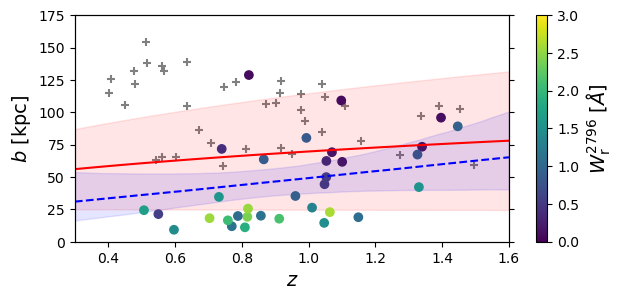

In [1067]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["Z"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
#cbar = plt.colorbar(im, ax=ax1, location='right', shrink=1, pad=0.1)
#cbar.set_label('Colorbar Label')
#ax1.colorbar(label = "$W^{2796}_{\mathrm{r}}$")
ax1.scatter(isol_9_noabs["Z"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(10**zz-1, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(10**zz-1, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_z["z"]), np.array(fc_z["pbest"]), color = "blue", \
         linestyle = "--", label = "fc($0.1 \AA$) = 50%")
ax1.fill_between(np.array(fc_z["z"]), np.array(fc_z["plow"]), np.array(fc_z["phigh"]), color = "blue", alpha = 0.1)


ax2 = ax1.twinx()
ax1.set_xlim((0.3, 1.6))
ax1.set_ylim((0., 175))
ax2.set_ylim((0., 175))
ax1.set_ylabel("$b$ [kpc]", size = 14)
ax1.set_xlabel("$z$", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper right', fontsize = 12)
#ax2.legend(loc='upper right')

#plt.axhline(0.5, c = "r")
#plt.legend()

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

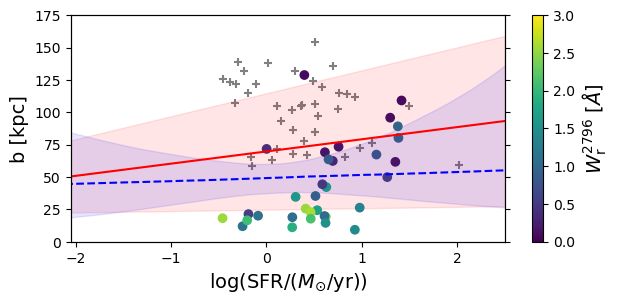

In [1068]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["logSFR"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["logSFR"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(sfr, bb01_sfr, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(sfr, bb01_sfr - sig01_sfr, bb01_sfr + sig01_sfr, color = "red", alpha = 0.1)
ax1.plot(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["pbest"]), color = "blue", linestyle = "--")
ax1.fill_between(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["plow"]), np.array(fc_sfr["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((-2.05, 2.5))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(SFR/($M_{\odot}$/yr))", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper left')
#plt.axhline(0.5, c = "r")

### Dvabs vs kinemativ 

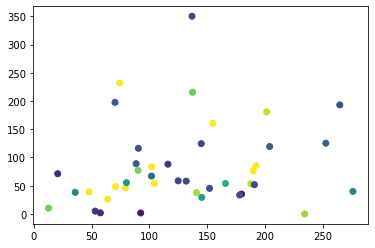

In [326]:
plt.scatter(isol_abs["v22"], isol_abs["vel_absorption_dist"]/1000, c = isol_abs["B_KPC"],\
           vmin = 0, vmax = 80)
#plt.ylim((0, 200))

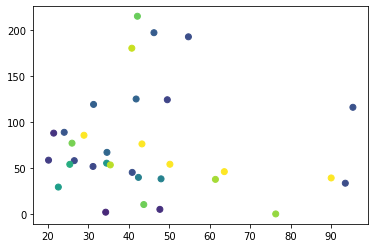

In [327]:
plt.scatter(isol_9_abs["velocity_dispersion_2Rd"], isol_9_abs["vel_absorption_dist"]/1000, c = isol_9_abs["B_KPC"],\
           vmin = 0, vmax = 80)

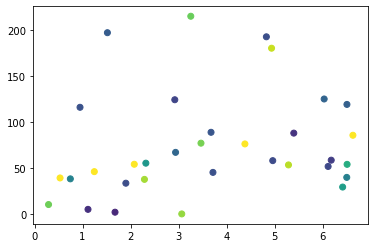

In [328]:
plt.scatter(isol_9_abs["v22"]/isol_9_abs["velocity_dispersion_2Rd"], \
            isol_9_abs["vel_absorption_dist"]/1000, c = isol_9_abs["B_KPC"],\
           vmin = 0, vmax = 80)

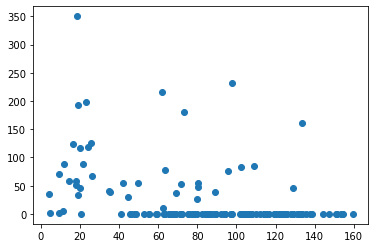

In [329]:
plt.scatter(isol["B_KPC"], isol["vel_absorption_dist"]/1000)

In [330]:
for c in isol_9.columns:
    print(c)

_id
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)
PSF_qso
Comments_qso
zqso_sdss
depth_qso
ebv_sfd_qso
ebv_sandf_qso
ebv_planck_qso
HST_qs

In [331]:
len(R_04_15_zconf1["abs_id"].unique())

112

In [332]:
kk = R_04_15[R_04_15["Z"]<1.4]

In [142]:
len(kk["abs_id"].unique())

110

# Disk halo decomposition

In [318]:
R = pd.read_csv("results_decomp_3.csv")

#bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]
low_cstr = [14120]
no_morpho = [11083, 12103, 20077, 21117, 23086, 24038, 25087, 27094, 29073, 30070]

no_morpho_isol = [11083, 12103, 20077, 23086, 24038, 27094, 30070]

to_remove = [11083, 24052]

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 30, "orientation"] = 0
R.loc[R["alpha"] > 60, "orientation"] = 2

In [319]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [320]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [321]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
fremove = R["ID"].isin(to_remove)

In [322]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fabs & fbehind & ~fremove]
isol_noabs = R[fqso & fstar & fisol & ~fabs & fbehind & ~fremove]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_snr3_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & fabs & ~fremove] # idem with good snr
isol_snr3_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fabs & ~fremove] # idem with good snr


isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind] # good runs
isol_snr3_good_runs_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot] # good runs
isol_snr3_good_runs_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs] # good runs
isol_snr3_good_runs_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs] # good runs

isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & frot] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & frot] # good runs


isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


#---- from visual inspection----
isol_behroozi = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & (fno_morpho | fremove)]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]

isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]


#----


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & ~fremove]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & ~fremove]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & ~fremove]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & ~fremove]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & ~fremove]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fremove]
closest_9_snr3_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & fabs & ~fremove]
closest_9_snr3_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fabs & ~fremove]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & ~fremove & ~fremove]
closest_9_snr3_good_runs_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fremove] # good runs
closest_9_snr3_good_runs_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs & ~fremove] # good runs
closest_9_snr3_good_runs_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs & ~fremove] # good runs
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & ~fremove]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & ~fremove]



closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]



print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated  = ", len(isol_snr3_good_runs_rot))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated with abs = ", len(isol_snr3_good_runs_rot_abs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated without abs= ", len(isol_snr3_good_runs_rot_noabs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))
print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  257
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and snr_eff > 3  =  51
Number of isolated with logM > 9 and good galpak runs  =  71
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  50
Number of isolated with logM > 9 and good galpak runs, rot dominated  =  43
Number of isolated with logM > 9 and good

In [323]:
len(isol_visu_rot)

57

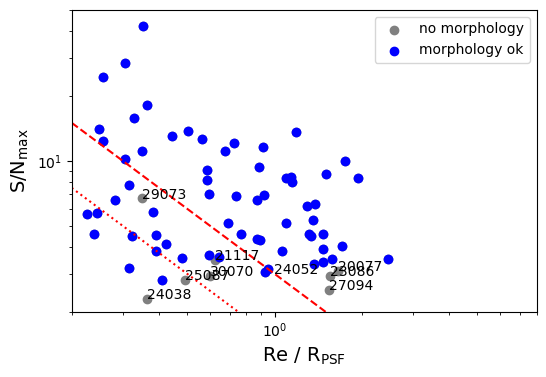

In [324]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

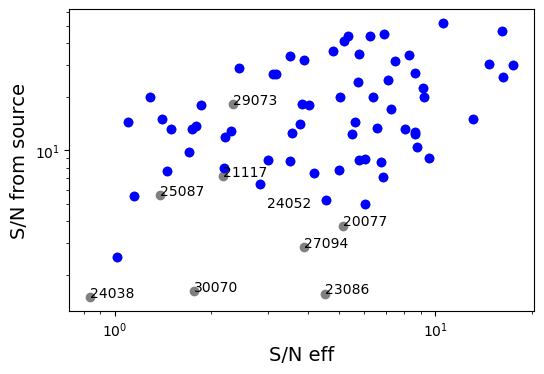

In [325]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

Text(0, 0.5, 'sed logM*')

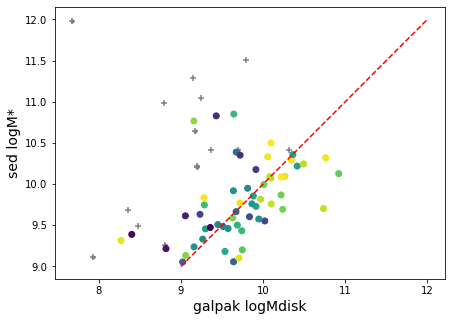

In [326]:
plt.figure(figsize = (7, 5))
plt.scatter(isol_9["log_Mdisk"], isol_9["sed_logMass"], c = "gray", marker = "+")
plt.scatter(isol_visu["log_Mdisk"], isol_visu["sed_logMass"], c = "grey", marker = ".")
plt.scatter(isol_visu_rot["log_Mdisk"], isol_visu_rot["sed_logMass"], \
            c = (isol_visu_rot["v22"]+0.01)/isol_visu_rot["velocity_dispersion_2Rd"])
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

**~5-10 problematic cases to investigate...**

Nb of isolated galaxies with logM>9 : 72


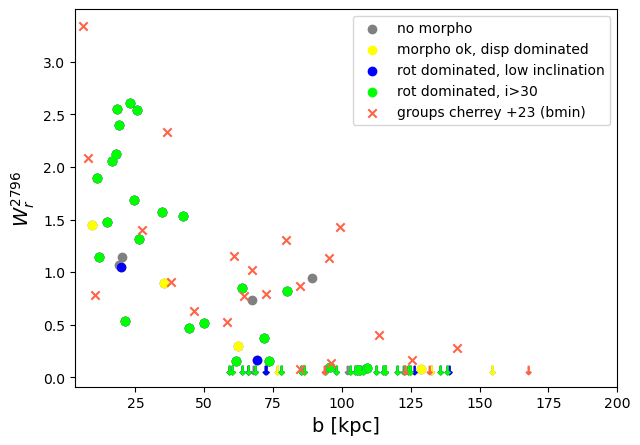

In [327]:
print("Nb of isolated galaxies with logM>9 :", len(isol_9))
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'gray',\
                 zorder = 2, label = "no morpho")
plt.scatter(isol_visu_abs["B_KPC"], isol_visu_abs["REW_2796"], c = 'yellow',\
                 zorder = 2, label = "morpho ok, disp dominated")
plt.scatter(isol_visu_rot_abs["B_KPC"], isol_visu_rot_abs["REW_2796"], c = 'blue',\
                 zorder = 2, label = "rot dominated, low inclination")
plt.scatter(isol_incl_visu_rot_abs["B_KPC"], isol_incl_visu_rot_abs["REW_2796"], c = 'lime',\
                 zorder = 2, label = "rot dominated, i>30")

plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "x", c = "tomato", zorder = 3, \
           label = "groups cherrey +23 (bmin)")

#plt.scatter(isol_high_alpha_abs["B_KPC"], isol_high_alpha_abs["REW_2796"], c = 'red',\
#                 label = "high alpha", zorder = 2)

#plt.scatter(isol_mid_alpha_abs["B_KPC"], isol_mid_alpha_abs["REW_2796"], c = 'lime',\
#                 label = "mid alpha", zorder = 2)

#plt.scatter(isol_low_alpha_abs["B_KPC"], isol_low_alpha_abs["REW_2796"], c = 'blue',\
#                 label = "low alpha", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")
plt.scatter(isol_visu_noabs["B_KPC"], isol_visu_noabs["detection_limit_p75"], c = 'yellow',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_visu_rot_noabs["B_KPC"], isol_visu_rot_noabs["detection_limit_p75"], c = 'blue',\
                 zorder = 2, marker = "$\downarrow$")
plt.scatter(isol_incl_visu_rot_noabs["B_KPC"], isol_incl_visu_rot_noabs["detection_limit_p75"], c = 'lime',\
                 zorder = 2, marker = "$\downarrow$")

#plt.scatter(isol_high_alpha_noabs["B_KPC"], isol_high_alpha_noabs["detection_limit_p75"], c = "red",\
#             marker = "$\downarrow$")

#plt.scatter(isol_mid_alpha_noabs["B_KPC"], isol_mid_alpha_noabs["detection_limit_p75"], c = "lime",\
#             marker = "$\downarrow$")

#plt.scatter(isol_low_alpha_noabs["B_KPC"], isol_low_alpha_noabs["detection_limit_p75"], c = "blue",\
#             marker = "$\downarrow$")

plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["REW_2796"]+0.075, marker = "$\downarrow$", c = "tomato", zorder = 3)

#plt.colorbar(label = "N2000")
plt.xlim((3, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
plt.legend()

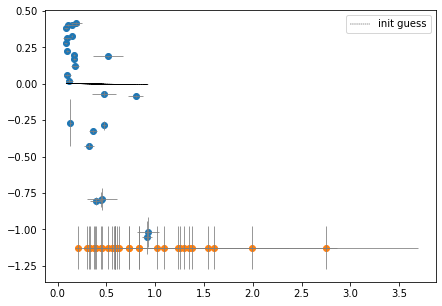

In [328]:
x1 = np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"])
x2 = np.array(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"])
y1 = np.array(np.log10(isol_visu_rot_abs["REW_2796"]))
y2 = np.array(np.log10(isol_visu_rot_noabs["detection_limit_p75"]))
sig_x1 = np.array(isol_visu_rot_abs["B_KPC"]*isol_visu_rot_abs["Rvir_err"]/(isol_visu_rot_abs["Rvir"]**2))
sig_x2 = np.array(isol_visu_rot_noabs["B_KPC"]*isol_visu_rot_noabs["Rvir_err"]/(isol_visu_rot_noabs["Rvir"]**2))
sig_y1 = np.array(isol_visu_rot_abs["sig_REW_2796"]/isol_visu_rot_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

plt.figure(figsize = (7,5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.errorbar(x1, y1, xerr = sig_x1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, xerr = sig_x2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "black", linestyle = "--", linewidth = 0.4)
plt.legend()

In [329]:
fit_bnorm = minimize(gt.logL_stats_total, np.array([0.2,-3, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_bnorm_1sig = np.diag(fit_bnorm.hess_inv)**0.5
fit_bnorm_1sig_inf = fit_bnorm['x'] - fit_bnorm_1sig
fit_bnorm_1sig_sup = fit_bnorm['x'] + fit_bnorm_1sig
fit_bnorm

      fun: 42.25938380857636
 hess_inv: array([[ 4.44522442e-02, -8.02122806e-02, -4.68060699e-05],
       [-8.02122806e-02,  2.27079003e-01, -1.54511754e-02],
       [-4.68060699e-05, -1.54511754e-02,  1.29385122e-02]])
      jac: array([ 4.76837158e-07,  0.00000000e+00, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 19
     njev: 21
   status: 0
  success: True
        x: array([ 0.18982305, -2.491955  ,  0.71559092])

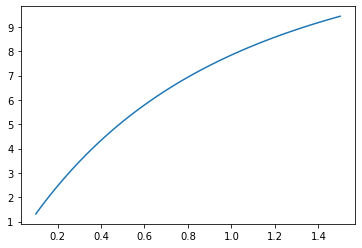

In [330]:
z = np.linspace(0.1, 1.5, 50)
plt.plot(z, cosmo.lookback_time(z))

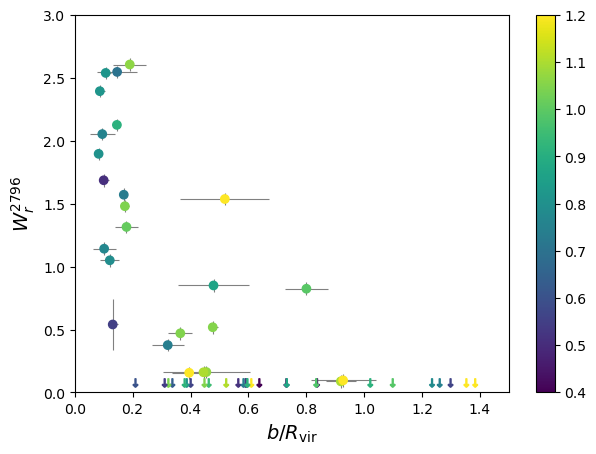

In [331]:
plt.figure(figsize = (7, 5), dpi = 100)
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

X = np.linspace(0.05, 4, 100)
#plt.plot(X, 10**gt.model(fit_bnorm['x'], X), linewidth = 1.0, c = "black", \
#         linestyle = "--", label = "best fit all")
#plt.fill_between(X, 10**gt.model(fit_bnorm_1sig_inf, X), 10**gt.model(fit_bnorm_1sig_sup, X), \
#                 color = "gray", alpha = 0.2, linewidth = 0)

plt.scatter(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"], isol_visu_rot_abs["REW_2796"],\
            c = isol_visu_rot_abs["Z"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0.4, vmax = 1.2)
plt.colorbar()
plt.errorbar(np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"]), \
            np.array(isol_visu_rot_abs["REW_2796"]),\
            xerr = np.array(isol_visu_rot_abs["B_KPC"]*isol_visu_rot_abs["Rvir_err"]/(isol_visu_rot_abs["Rvir"]**2)),\
            yerr = np.maximum(isol_visu_rot_abs["sig_REW_2796"], 0.05),\
             linestyle = "none", c = "grey", linewidth = 0.8, zorder = 1)
plt.scatter(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"], isol_visu_rot_noabs["detection_limit_p75"],\
            c = isol_visu_rot_noabs["Z"],\
             marker = "$\downarrow$", vmin = 0.4, vmax = 1.2)
#plt.colorbar(label = "$\\alpha$")

plt.xlim((0.00, 1.5))
plt.ylim((0.00, 3))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b / R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{r}$", size = 14)
#plt.legend()

X = np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"])
Y = np.array(isol_visu_rot_abs["REW_2796"])
txt = np.array(isol_visu_rot_abs["ID"])

#for i in range(len(isol_visu_rot_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


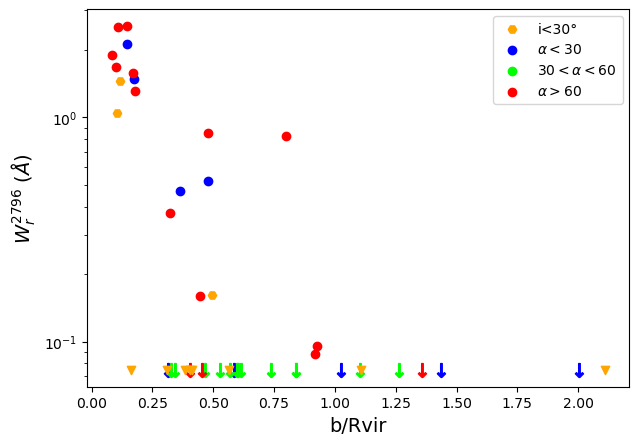

In [332]:
plt.figure(figsize = (7,5), dpi = 100)
X = np.linspace(0, 150, 200)

#plt.plot(X, 10**gt.model(fit_9['x'], X), linewidth = 1.0, c = "black", \
#         linestyle = "--", label = "fit $\log(M_*/M_{\odot})$>9")
#plt.fill_between(X, 10**gt.model(fit_9_1sig_inf, X), 10**gt.model(fit_9_1sig_sup, X), \
#                 color = "gray", alpha = 0.2, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_lowa['x'], X), linewidth = 1.0, c = "blue", \
#         linestyle = "dashdot", label = "best fit $\\alpha<30°$")
#plt.fill_between(X, 10**gt.model(fit_lowa_1sig_inf, X), 10**gt.model(fit_lowa_1sig_sup, X), \
#                color = "blue", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_higha['x'], X), linewidth = 1.0, c = "red", \
#         linestyle = "dotted", label = "best fit $\\alpha>60°$")
#plt.fill_between(X, 10**gt.model(fit_higha_1sig_inf, X), 10**gt.model(fit_higha_1sig_sup, X), \
#                 color = "red", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_lowi['x'], X), linewidth = 1.0, c = "orange", \
#         linestyle = "dotted", label = "best fit $i<30°$")
#plt.fill_between(X, 10**gt.model(fit_lowi_1sig_inf, X), 10**gt.model(fit_lowi_1sig_sup, X), \
#                 color = "orange", alpha = 0.1, linewidth = 0)

#plt.plot(X, 10**gt.model(fit_mida['x'], X), linewidth = 1.0, c = "lime", \
#         linestyle = "dotted", label = "best fit $30°<\\alpha<60°$")
#plt.fill_between(X, 10**gt.model(fit_mida_1sig_inf, X), 10**gt.model(fit_mida_1sig_sup, X), \
#                 color = "lime", alpha = 0.1, linewidth = 0)

#-----------------------------------
#plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = "gray")
#plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], \
#            c = "gray", marker = "$\downarrow$", s = 100,)

#plt.scatter(isol_visu_nok_abs["B_KPC"]/isol_visu_nok_abs["Rvir"], isol_visu_nok_abs["REW_2796"], edgecolors = 'black',\
#                 zorder = 2, label = "no morphology", facecolors = "none")
#plt.scatter(isol_visu_disp_abs["B_KPC"]/isol_visu_disp_abs["Rvir"], isol_visu_disp_abs["REW_2796"], c = 'black',\
#                 zorder = 2, label = "disp. dominated", marker = "*")
plt.scatter(isol_visu_low_incl_abs["B_KPC"]/isol_visu_low_incl_abs["Rvir"], isol_visu_low_incl_abs["REW_2796"], c = 'orange',\
                 zorder = 2, label = "i<30°", marker = "H")
plt.scatter(isol_visu_low_incl_noabs["B_KPC"]/isol_visu_low_incl_noabs["Rvir"], isol_visu_low_incl_noabs["detection_limit_p75"], c = 'orange',\
                 zorder = 2, marker = "v")
#plt.scatter(isol_visu_nok_noabs["B_KPC"]/isol_visu_nok_noabs["Rvir"], isol_visu_nok_noabs["detection_limit_p75"], edgecolors = 'black',\
#                 zorder = 2, facecolors = "none", marker = "v")
#plt.scatter(isol_visu_disp_noabs["B_KPC"]/isol_visu_disp_noabs["Rvir"], isol_visu_disp_noabs["detection_limit_p75"], c = 'black',\
#                 zorder = 2, marker = "d")
#plt.errorbar(np.array(isol_9_abs["B_KPC"]), np.array(isol_9_abs["REW_2796"]),\
#             yerr = np.maximum(isol_9_abs["sig_REW_2796"], 0.05), \
#             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1)
#plt.errorbar(np.array(isol_9_noabs["B_KPC"]), np.array(isol_9_noabs["detection_limit_p75"]),\
#             yerr = np.maximum(isol_9_noabs["detection_limit_p75"], 0.05), \
#             c = "grey", linestyle = "none", linewidth = 0.8, zorder = 1)


plt.scatter(isol_low_alpha_abs["B_KPC"]/isol_low_alpha_abs["Rvir"], isol_low_alpha_abs["REW_2796"], c = "blue", zorder = 2, \
            label = "$\\alpha<30$")
plt.scatter(isol_low_alpha_noabs["B_KPC"]/isol_low_alpha_noabs["Rvir"], isol_low_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "blue")

plt.scatter(isol_mid_alpha_abs["B_KPC"]/isol_mid_alpha_abs["Rvir"], isol_mid_alpha_abs["REW_2796"], c = "lime", zorder = 2,\
           label = "$30 < \\alpha<60$")
plt.scatter(isol_mid_alpha_noabs["B_KPC"]/isol_mid_alpha_noabs["Rvir"], isol_mid_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "lime")

plt.scatter(isol_high_alpha_abs["B_KPC"]/isol_high_alpha_abs["Rvir"], isol_high_alpha_abs["REW_2796"], c = "red", zorder = 2,\
           label = "$\\alpha>60$")
plt.scatter(isol_high_alpha_noabs["B_KPC"]/isol_high_alpha_noabs["Rvir"], isol_high_alpha_noabs["detection_limit_p75"], \
            marker = "$\downarrow$", s = 100, c = "red")




plt.xlabel("b/Rvir", size = 14)
plt.ylabel("$W_r^{2796}$ ($\AA$)", size = 14)
#plt.ylim((0.05, 3.5))
#plt.xlim((0, 2))
plt.legend()
plt.yscale("log")
#plt.xscale("log")

(0.0, 1.5)

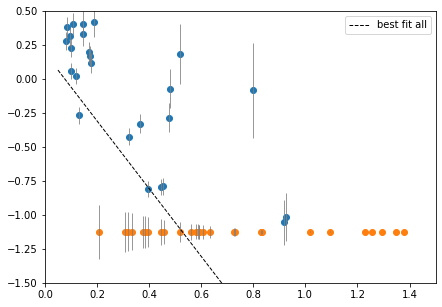

In [333]:
from scipy.stats import norm
param = fit_bnorm['x']
residuals = (param[0] + x1*param[1]) - y1
log_likelihood = norm.logpdf(residuals, scale = (sig_y1**2 + param[2]**2)**0.5)

residuals_sup = y2 - (param[0] + x2*param[1])
log_likelihood_sup = norm.logcdf(residuals_sup, scale = (sig_y2**2 + param[2]**2)**0.5)

plt.figure(figsize = (7,5))
#plt.axhline(0, c = "red", linestyle = "--")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
#plt.errorbar(x1, y1, xerr = sig_x1, yerr = sig_y1, c = "gray", linestyle = "none", linewidth = 0.8)
#plt.errorbar(x2, y2, xerr = sig_x2, yerr = sig_y2, c = "gray", linestyle = "none", linewidth = 0.8)


plt.errorbar(x1, y1, yerr = log_likelihood/10, c = "gray", linestyle = "none", linewidth = 0.8)
plt.errorbar(x2, y2, yerr = log_likelihood_sup/10, c = "gray", linestyle = "none", linewidth = 0.8)

#plt.plot(x0, A + B*x0, label = "true function", c = "black")

X = np.linspace(0.05, 1, 100)
plt.plot(X, gt.model(fit_bnorm['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all")
#plt.plot(x1, 0.001 -0.008*x1, label = "init guess", c = "black", linestyle = "--", linewidth = 0.4)
plt.legend()
plt.ylim((-1.5, 0.5))
plt.xlim((0, 1.5))

main sequence

In [334]:
len(isol_behroozi)

65

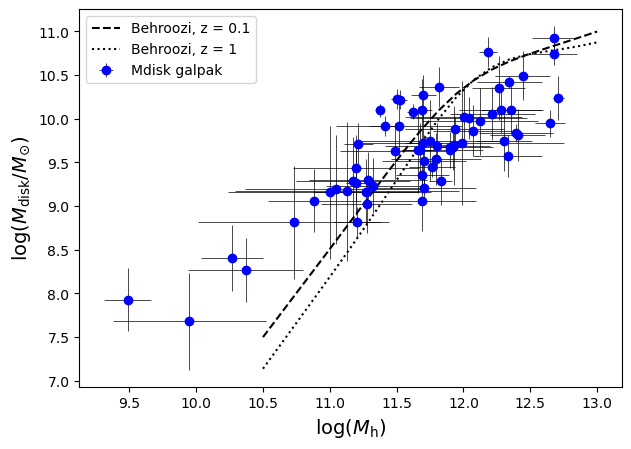

In [335]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(isol_behroozi["log_Mvir"]), np.array(isol_behroozi["log_Mdisk"]),\
             xerr = np.array(isol_behroozi["log_Mvir_err"]), \
             yerr = np.array(isol_behroozi["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", color = "blue", marker = "o", ecolor = "black", \
            linewidth = 0.5)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(isol_behroozi["log_Mvir"])
Y = np.array(isol_behroozi["log_Mdisk"])
txt = np.array(isol_behroozi["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

In [336]:
len(isol_visu)

64

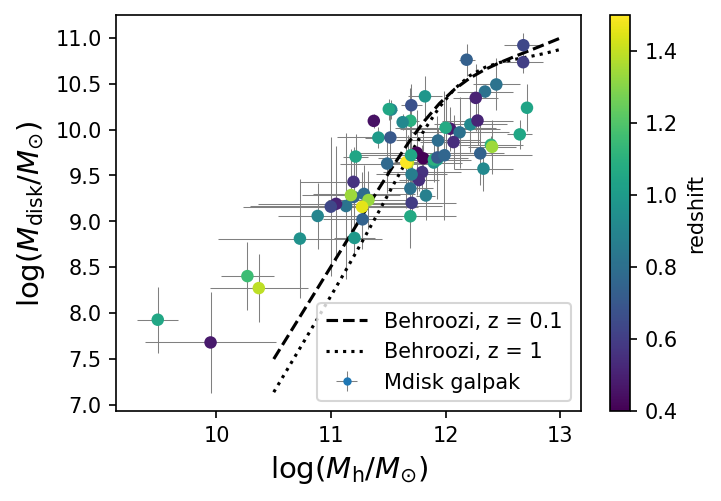

In [338]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (5,3.5), dpi = 150)
plt.errorbar(np.array(isol_visu["log_Mvir"]), np.array(isol_visu["log_Mdisk"]),\
             xerr = np.array(isol_visu["log_Mvir_err"]), \
             yerr = np.array(isol_visu["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", marker = ".", ecolor = "gray", \
            linewidth = 0.5)
plt.scatter(np.array(isol_visu["log_Mvir"]), np.array(isol_visu["log_Mdisk"]),\
             c = np.array(isol_visu["Z"]), edgecolor = "none", vmin = 0.4, vmax = 1.5, zorder = 3)
plt.colorbar(label = "redshift")
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}}/M_{\odot})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(isol_visu["log_Mvir"])
Y = np.array(isol_visu["log_Mdisk"])
txt = np.array(isol_visu["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

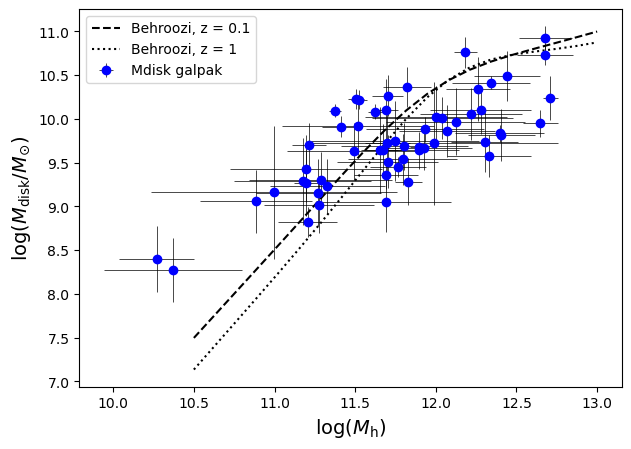

In [163]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(isol_visu_rot["log_Mvir"]), np.array(isol_visu_rot["log_Mdisk"]),\
             xerr = np.array(isol_visu_rot["log_Mvir_err"]), \
             yerr = np.array(isol_visu_rot["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", color = "blue", marker = "o", ecolor = "black", \
            linewidth = 0.5)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(isol_visu_rot["log_Mvir"])
Y = np.array(isol_visu_rot["log_Mdisk"])
txt = np.array(isol_visu_rot["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

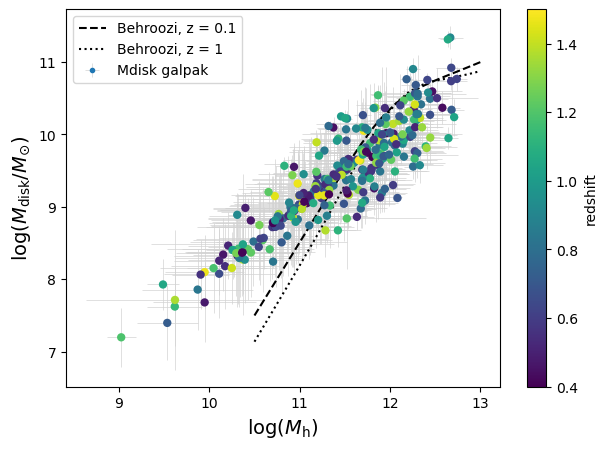

In [164]:
R_04_15_zconf1
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(R_04_15_zconf1["log_Mvir"]), np.array(R_04_15_zconf1["log_Mdisk"]),\
             xerr = np.array(R_04_15_zconf1["log_Mvir_err"]), \
             yerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", marker = ".", ecolor = "lightgray", \
            linewidth = 0.5)
plt.scatter(np.array(R_04_15_zconf1["log_Mvir"]), np.array(R_04_15_zconf1["log_Mdisk"]),\
             c = np.array(R_04_15_zconf1["Z"]), edgecolor = "none", vmin = 0.4, vmax = 1.5, zorder = 3)
plt.colorbar(label = "redshift")
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(R_04_15_zconf1["log_Mvir"])
Y = np.array(R_04_15_zconf1["log_Mdisk"])
txt = np.array(R_04_15_zconf1["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

# Catalog figure

In [165]:
len(isol_visu)

64

In [166]:
65/3

21.666666666666668

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
run_dir = output_path

lines_dict = {"HALPHA":"ha", "HBETA": "hb", "HDELTA": "hd", "HGAMMA": "hg", "OII":"o2", "OIII5007": "o3"}
k = 0

Nrows = 22
Ncols = 3

fig = plt.figure(figsize=(15, 60),constrained_layout=False)
gs = fig.add_gridspec(nrows = Nrows, ncols = Ncols*2+3, wspace=0.0, hspace=0.1,\
                     width_ratios = [1,1,0.3,1,1,0.3,1,1,0.01])

for i, r in isol_visu.iterrows():
    if k < Nrows*Ncols:
        field_id = r["field_id"]
        src_id = r["ID"] 
        run_name = r["run_name"]
        #print(r["run_name"])
        try:
            line = (r["run_name"]).split("_")[1]
        except:
            line = "Nan"
        z_src = r["Z"]
        REW2796 =r["REW_2796"]
        B_KPC = r["B_KPC"]
        incl = r["inclination"]
        alpha = r["alpha"]
        radius = r["radius"]
        snr_eff = r["snr_eff"]
        primary_auto = r["primary_auto"]
        isolated_auto = r["isolated_auto"]
        logMass = r["sed_logMass"]
        #print(output_dir, run_name, src_id, field_id)
        
        txt = str(src_id)+" - z = "+str(np.round(z_src, 3)) 
        if line == "OII":
            txt_line ="[OII]"
        elif line == "OIII5007":
            txt_line = "[OIII]"
        elif line == "HBETA":
            txt_line = "H$_{\\beta}$"

        row = k//Ncols
        col = k - (k//Ncols)*Ncols
        #print(row, col)
        # Create the Axes.
        #ax_meas = fig.add_subplot(gs[2*col:2*col+1, row:row+1])
        #ax_model = fig.add_subplot(gs[2*col+1:2*col+2, row:row+1])
        #ax_meas = fig.add_subplot(gs[row:row+1, 2*col:2*col+1])
        ax_velmap = fig.add_subplot(gs[row:row+1, 3*col:3*col+1])
        ax_model = fig.add_subplot(gs[row:row+1, 3*col+1:3*col+2])
        ax_empty = fig.add_subplot(gs[row:row+1, 3*col+2:3*col+3])
        
        ax_empty.axis("off")
        ax_model.set_yticklabels([])
        
        if row != Nrows-1:
            #ax_velmap.set_xticklabels([])
            #ax_model.set_xticklabels([])
            pass
        else:
            ax_model.set_xlabel("x [kpc]", size = 12)
            ax_velmap.set_xlabel("x [kpc]", size = 12)
        if col != 0:
            #ax_velmap.set_yticklabels([])
            pass
        else:
            ax_velmap.set_ylabel("y [kpc]", size = 12)
        #ax_model.set_yticklabels([])
        
        
        

        if type(run_name) is str and "cont" not in run_name:
            run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"
            src_dir = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"
            src_file = src_dir + field_id +"_source-"+str(src_id)+"_"+line+"_cube_nocont.fits"
            src_origin_file = input_path+field_id+"/products/sources/"+field_id +"_source-"+str(src_id)+".fits"
            #src = Source.from_file(src_origin_file)
            hdul = fits.open(src_file)
            data = hdul[1].data
            dd = data.sum(axis = 0)
            smoothed_data = gaussian_filter(dd, sigma=1)
            #print(run_path)
            kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z_src).value/60
            extent_arcsec = np.array([-0.2*15, 0.2*15,-0.2*15, 0.2*15])
            extent_kpc = extent_arcsec*kpc_per_arcsec

            # For the measured flux:
            img_run = plt.imread(run_path + "run_images.png")
            img_measured = img_run[10:320, 140:440]

            # For the model:
            hdulist = fits.open(run_path + "run_obs_vel_map.fits")
            img_model = hdulist[0].data
            hdulist.close()

            # For the convergence:
            #img_conv = plt.imread(run_path + "run_mcmc.png")

            kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z_src).value/60
            extent_arcsec = np.array([-0.2*15, 0.2*15,-0.2*15, 0.2*15])
            extent_kpc = extent_arcsec*kpc_per_arcsec
            #ax_meas.imshow(smoothed_data, extent = extent_kpc)
            #divider = make_axes_locatable(ax_meas)
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            #ax_meas.set_xlabel("x [kpc]", size = 12)
            #ax_meas.set_ylabel("y [kpc]", size = 12)
            #ax_meas.invert_yaxis()
            #ax_meas.axis("off")

            ax_model.imshow(img_model, cmap = "bwr", vmin = -150, vmax = 150, extent = extent_kpc)
            ax_model.invert_yaxis()
            #ax_model.set_xlabel("x [kpc]", size = 12)
            #ax_model.set_ylabel("y [kpc]", size = 12)
            #ax_model.axis("off")

            #ax_conv.imshow(img_conv)
            #ax_conv.axis("off")

            # For the velmap:
            #try:
            vel = "camel_"+line+"/camel_"+ str(src_id) +"_"+lines_dict[line]+"_ssmooth" +"_vel_common.fits"
            snr = "camel_"+line+"/camel_"+ str(src_id) +"_"+lines_dict[line]+"_ssmooth" +"_snr_common.fits"
            velmap_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+vel
            snr_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+snr
            hdul_vel = fits.open(velmap_path)
            hdul_snr = fits.open(snr_path)
            img_vel = hdul_vel[0].data
            img_snr = hdul_snr[0].data
            #mask_obj = src.images["MASK_OBJ"]
            #ma = mask_obj.data
            m = np.where(img_snr>4, 1, 0)

            divider = make_axes_locatable(ax_velmap)
            #cax = divider.append_axes('right', size='5%', pad=0.05)
            im = ax_velmap.imshow(img_vel*m, vmin = -150, vmax = 150, cmap = "bwr", extent = extent_kpc)
            #fig.colorbar(im, cax=cax, orientation='vertical')
            #plt.colorbar(ax_velmap, label = "Dv [km/s]")
            #ax_velmap.set_xlabel("x [kpc]", size = 12)
            #ax_velmap.set_ylabel("y [kpc]", size = 12)
            ax_velmap.invert_yaxis()

            #except:
            #    print(src_id, ": no vel. map")
                #plt.subplot(133)
            #    ax_velmap.scatter(0,0, c = "white")

            ax_model.text(0.01, 0.9, txt, fontsize=10, transform=ax_model.transAxes)
            ax_model.text(0.01, 0.05, txt_line, fontsize=10, transform=ax_model.transAxes)

        else:
            print(src_id ,": no run" , run_name, type(run_name))
            #plt.subplot(131)
            #ax_meas.scatter(0,0, c = "white")
            #ax_meas.axis("off")
    k+=1

In [ ]:
vvv = 150*u.km/u.s
vv = vvv.to(u.kpc/u.Myr)
ttt = 100*u.kpc/vv
ttt

In [ ]:
plt.scatter(isol_9["velocity_dispersion"], isol_9["velocity_dispersion_2Rd"])

In [ ]:
len(isol_visu)

# Passive galaxies

In [333]:
len(closest_9)

241

In [334]:
f_ssfr_01 = isol_9["logSFR"]< np.log10(10**isol_9["sed_logMass"]*1e-10) #sSFR = 0.1 per Gyr
f_ssfr_01_clos = closest_9["logSFR"]< np.log10(10**closest_9["sed_logMass"]*1e-10) #sSFR = 0.1 per Gyr


passive_9 = isol_9[f_ssfr_01]
passive_9_clos = closest_9[f_ssfr_01_clos]

(-2.5, 2.5)

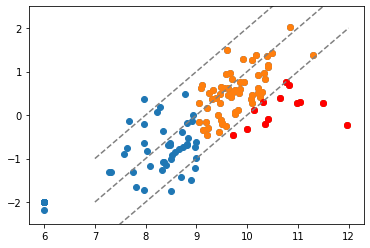

In [335]:
sSFR_1 = 1e-9 # per Gyr
sSFR_10 = 1e-8 # per Gyr
sSFR_01 = 1e-10 # per Gyr
mm = np.linspace(7,12,4)
sfr_1 = np.log10((10**mm)*sSFR_1)
sfr_10 = np.log10((10**mm)*sSFR_10)
sfr_01 = np.log10((10**mm)*sSFR_01)
plt.scatter(isol["sed_logMass"], isol["logSFR"])
plt.scatter(isol_9["sed_logMass"], isol_9["logSFR"])
plt.scatter(passive_9["sed_logMass"], passive_9["logSFR"], color = "r")

plt.plot(mm,sfr_1, linestyle = "--", color = "gray")
plt.plot(mm,sfr_10, linestyle = "--", color = "gray")
plt.plot(mm,sfr_01, linestyle = "--", color = "gray")
plt.ylim((-2.5,2.5))

(-2.5, 2.5)

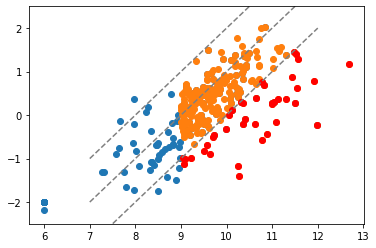

In [336]:
sSFR_1 = 1e-9 # per Gyr
sSFR_10 = 1e-8 # per Gyr
sSFR_01 = 1e-10 # per Gyr
mm = np.linspace(7,12,4)
sfr_1 = np.log10((10**mm)*sSFR_1)
sfr_10 = np.log10((10**mm)*sSFR_10)
sfr_01 = np.log10((10**mm)*sSFR_01)
plt.scatter(isol["sed_logMass"], isol["logSFR"])
plt.scatter(closest_9["sed_logMass"], closest_9["logSFR"])
plt.scatter(passive_9_clos["sed_logMass"], passive_9_clos["logSFR"], color = "r")

plt.plot(mm,sfr_1, linestyle = "--", color = "gray")
plt.plot(mm,sfr_10, linestyle = "--", color = "gray")
plt.plot(mm,sfr_01, linestyle = "--", color = "gray")
plt.ylim((-2.5,2.5))

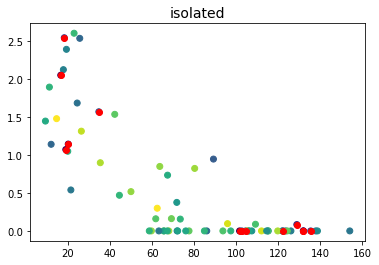

In [337]:
plt.title("isolated", size = 14)
plt.scatter(isol_9["B_KPC"], isol_9["REW_2796"], c = np.log10(isol_9["SFR_gilbank"]/(10**isol_9["sed_logMass"])),\
           vmin = -10.5, vmax = -8.5)
plt.scatter(passive_9["B_KPC"], passive_9["REW_2796"], c = "r")

In [338]:
isol_9["vel_absorption_dist"]

74           0.000000
94           0.000000
230          0.000000
294      39823.882767
314     193090.807722
            ...      
1923         0.000000
1930         0.000000
1994     54033.236133
1998         0.000000
2019         0.000000
Name: vel_absorption_dist, Length: 72, dtype: float64

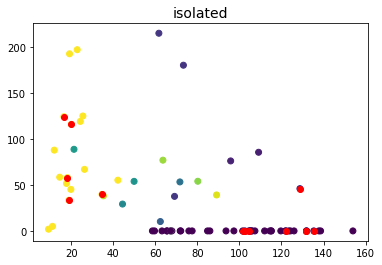

In [339]:
plt.title("isolated", size = 14)
plt.scatter(isol_9["B_KPC"], isol_9["vel_absorption_dist"]/1e3, c = isol_9["REW_2796"],\
           vmin = 0, vmax = 1)
plt.scatter(passive_9["B_KPC"], passive_9["vel_absorption_dist"]/1e3, c = "r",\
           vmin = 0, vmax = 1)

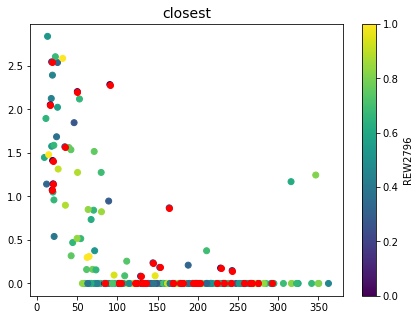

In [340]:
plt.figure(figsize = (7,5))
plt.title("closest", size = 14)
plt.scatter(closest_9["B_KPC"], closest_9["REW_2796"], \
            c = np.log10(closest_9["SFR_gilbank"]/(10**closest_9["sed_logMass"])),\
           vmin = -10.5, vmax = -8.5)
plt.scatter(passive_9_clos["B_KPC"], passive_9_clos["REW_2796"], c = "r")
plt.colorbar(label = "REW2796")

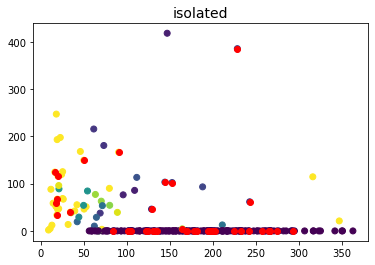

In [341]:
plt.title("isolated", size = 14)
plt.scatter(closest_9["B_KPC"], closest_9["vel_absorption_dist"]/1e3, c = closest_9["REW_2796"],\
           vmin = 0, vmax = 1)
plt.scatter(passive_9_clos["B_KPC"], passive_9_clos["vel_absorption_dist"]/1e3, c = "r",\
           vmin = 0, vmax = 1)

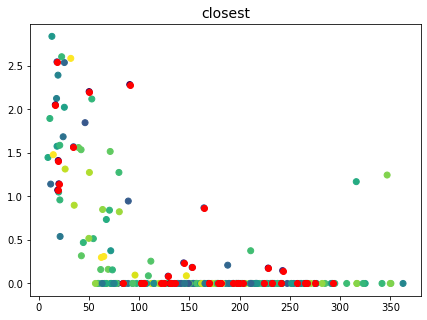

In [342]:
plt.figure(figsize = (7,5))
plt.title("closest", size = 14)
plt.scatter(closest_9["B_KPC"], closest_9["REW_2796"], \
            c = np.log10(closest_9["SFR_gilbank"]/(10**closest_9["sed_logMass"])),\
           vmin = -10.5, vmax = -8.5)
plt.scatter(passive_9_clos["B_KPC"], passive_9_clos["REW_2796"], c = "r")


In [343]:
isol_9["sed_logMass_ERR"]

74      0.012118
94      0.053073
230     0.103716
294     0.014034
314     0.029345
          ...   
1923    0.188478
1930    0.042865
1994    0.045275
1998    0.244581
2019    0.094686
Name: sed_logMass_ERR, Length: 72, dtype: float64

In [344]:
600/13

46.15384615384615

In [345]:
0.25*150

37.5